#  <span style="color:green">Tutorial - Kernel based perception with Gaussian Processes</span>

This tutorial implements Gaussian Processes (GP) to interpret a robot's surroundings using range and bearing observations. We cover:
- Classification: Identifying the same landmark object in re-observations
- Regression: Determining the likelihood of re-observations based on continuous models of previous observations

Classes and functions in course libraries `model_feeg6043.py` and `math_feeg6043.py` and `plot_feeg6043.py` are used.

<img src="./images/B1_1_Tutorial_Overview.png" alt="Tutorial Overview" width="800px" align="center"/>    

## Gaussian Processes Theory Recap

GPs model the output value of a function as $\mathbf{f}$ corresponding to any input variable $\mathbf{X}$, as having a Gaussian distribution.

\begin{align}
p(\mathbf{f}|\mathbf{X}) = \mathcal{N}(\mathbf{f}|\boldsymbol{\mu},\mathbf{K})
\end{align}

This is achieved using multiple functions (processes), where the flexibility and distribution of these is controlled by a covariance matrix $\mathbf{K}=K(\mathbf{X},\mathbf{X})$, which itself is based on a kernel function $K$. Observations $\mathbf{f}$ are assumed to contain noise:

\begin{align}
\mathbf{z} = \mathbf{f}(\mathbf{X}) + \epsilon
\end{align}

where $\epsilon$ is independent Gaussian noise with variance $\sigma^2_n$. The covariance becomes:

\begin{align}
\mathrm{cov}(\mathbf{z}) = K(\mathbf{X},\mathbf{X})+ \sigma^2_n\mathbf{I}
\end{align}

GPs predict what the noise free observations $\mathbf{f}_*$ would be for any input $\mathbf{X}_*$ through the joint distribution of $\mathbf{z}$ and $\mathbf{f}_*$ as: 

\begin{align}
\begin{pmatrix} \mathbf{z}\\ \mathbf{f}_* \end{pmatrix} \sim \mathcal{N} \left( 0, \begin{bmatrix} \mathbf{K}+\sigma^2_n \mathbf{I} & \mathbf{K}_* \\ \mathbf{K}^T_* & \mathbf{K}_{**} \end{bmatrix} \right)
\end{align}

where $\mathbf{K}=K(\mathbf{X},\mathbf{X})$, $\mathbf{K}_*=K(\mathbf{X},\mathbf{X}_*)$ and $\mathbf{K}_{**}=K(\mathbf{X}_*,\mathbf{X}_*)$. The mean is assumed to be $\left(m(\mathbf{X}),m(\mathbf{X}_*)\right)=0$, which is not limiting as the mean of the measurements can be added to the prediction. The GP prediction is conditional distribution:

\begin{align}
p(\bar{\mathbf{f}}_*|\mathbf{X},\mathbf{z},\mathbf{X}_*) \sim \mathcal{N} \left(\bar{\mathbf{f}}_*, \mathrm{cov}(\mathbf{f}_*)\right)
\end{align}

where we define $\bar{\mathbf{f}}_*$ and $\mathrm{cov}(\mathbf{f}_*)$ as:

\begin{align}
\mu &=& \bar{\mathbf{f}}_* = \mathbf{K}^T_*[\mathbf{K}+\sigma^2_n\mathbf{I}]^{-1}\mathbf{z}\\
\Sigma &=& \mathrm{cov}(\mathbf{f}_*) = \mathbf{K}_{**}-\mathbf{K}^T_*[\mathbf{K}+\sigma^2_n\mathbf{I}]^{-1}\mathbf{K}_{*}
\end{align}

For classification, kernel parameters can be opitimised using the Laplace approximation of the posterior. 

\begin{align}
\log p(\mathbf{c}|\mathbf{X},\Theta) \approx \log q(\mathbf{c}|\mathbf{X},\Theta) = -\dfrac{1}{2} \hat{\mathbf{f}}^T \mathbf{K}^{-1}\hat{\mathbf{f}} -\sum_i \log(1+\exp(\mathbf{f_i})) + \mathbf{c}^T\mathbf{f} - \dfrac{1}{2}\log|I+W^{\frac{1}{2}}\mathbf{K}W^{\frac{1}{2}}|
\end{align}

Once we have our posterior function, we can make class predictions as:

\begin{align}
p(\mathbf{c}_*=1 | \mathbf{c}) = \int{p(\mathbf{c}_*=1 | \mathbf{f}_*) p(\mathbf{f}_* | \mathbf{c}) d \mathbf{f}_*}
\end{align}

This has no analytical solution and so needs to be approximated. A method to achieve this was proposed by MacKay 1992 as:

\begin{align}
&&\kappa(\mathbf{f}_*|\mathbf{f}) = \left(1 + \frac{\pi}{8} \sigma^2_{\mathbf{f}_*}\right)^{-1}\\
&&p(\mathbf{c}_*=1 | \mathbf{c}) \approx \lambda(\mathbf{f}_* \kappa^{0.5})
\end{align}

where $\lambda$ is the linear logistic function

\begin{align}
\lambda(z) &=& \dfrac{1}{1+\exp(-z)}
\end{align}

*D. J. C. MacKay, "The Evidence Framework Applied to Classification Networks," in Neural Computation, vol. 4, no. 5, pp. 720-736, Sept. 1992, doi: 10.1162/neco.1992.4.5.720.*

## 1. GP Classification in 1D

Binary classifiers can be used for multi-class classification by sequentially determining the likelihood if being in each class and picking the most likely class. Binary classifiers consist of:

- A function that models some input-output relationship (we use the linear logistic function, constrained by a RBF kernel based covariance matrix)
- Algorithm to optimise the function's parameters (in this case the RBF kernel's parameters) based on some training data
- A decision boundary (for binary classifiers we use p(c=1)=0.5)

### Training and test data
We generate some synthetic data for training and testing 1D binary classification, where class $\mathbf{c}$ depends only on the input value of $\mathbf{X}$. 

*The cell below generates some traning data*

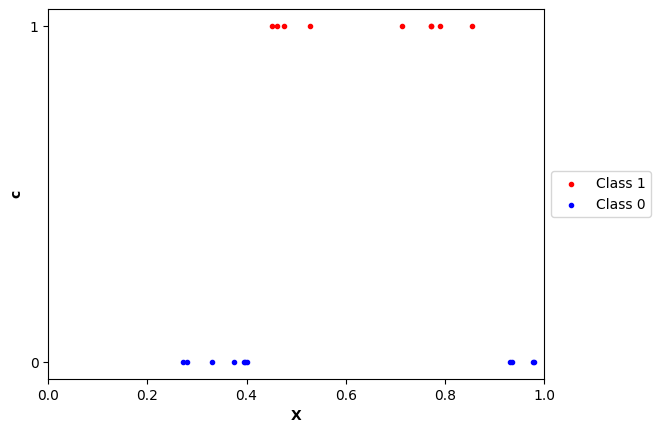

In [1]:
from math_feeg6043 import Matrix, Vector,Inverse
import matplotlib.pyplot as plt
import numpy as np

# generate some binary class training data, we leave a gap between 0.0-0.2 on purpose to see how the uncertianty changes
X = np.random.uniform(0.2,1,20)[:,None] # the syntax [:,None] makes a column vector

def synthetic_classes(X):
    z = -np.sin(X * np.pi/0.45) 

    # binarise the example
    for i in range(len(z)): 
        if z[i] > 0: z[i]=1
        else: z[i]=0
    return z

z=synthetic_classes(X)

# label each class
class_0 = z == 0
class_1 = z == 1

# plot the data
plt.scatter(X[class_1], z[class_1], label='Class 1', marker='.', color='red')
plt.scatter(X[class_0], z[class_0], label='Class 0', marker='.', color='blue')
plt.xlabel('$\mathbf{X}$'); plt.ylabel('$\mathbf{c}$')
plt.xlim([0,1])
plt.yticks([0, 1]); plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

We also generate some test data and corresponding classes to validate what our classifier does

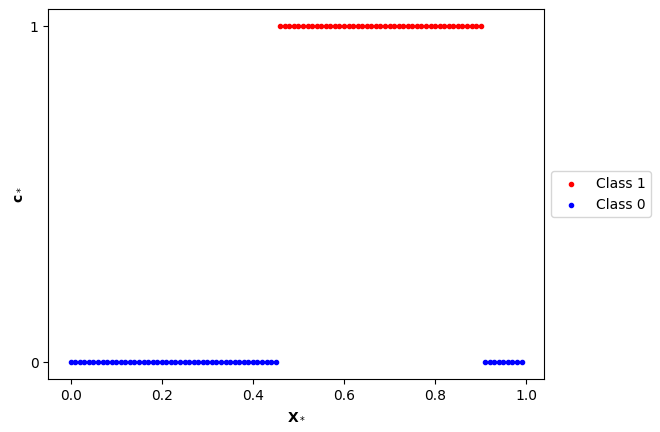

In [2]:
X_test = np.arange(0, 1, 0.01)[:,None] #this makes it a column vector

z_test=synthetic_classes(X_test)

# label each class
class_0_test = z_test == 0
class_1_test = z_test == 1

# plot the data
plt.scatter(X_test[class_1_test], z_test[class_1_test], label='Class 1', marker='.', color='red')
plt.scatter(X_test[class_0_test], z_test[class_0_test], label='Class 0', marker='.', color='blue')
plt.xlabel('$\mathbf{X}_*$'); plt.ylabel('$\mathbf{c}_*$')
plt.yticks([0, 1]); plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Model functions (classifier and Kernel)

The function used to model the class probabilistics is the logistic function:

\begin{align}
\lambda(z) &=& \dfrac{1}{1+\exp(-z)}
\end{align}

The inputs to these are generated by some function $\mathbf{z}=\mathbf{f}(X)$. The simplest is a linear function ($\mathbf{z}=w_1 X + w_0$) but for GPC, we use a Gaussian processes. 

Below we look at how the logistic function responds to the parameters of a linear input. The linear equation determines what part of the logistic curve acts on the inputs.

- **Task** Try changing linear function parameters $\mathbf{w}=[-3,10], \mathbf{w}=[-7,10], \mathbf{w}=[-70,100], \mathbf{w}=[-0.7,1]$

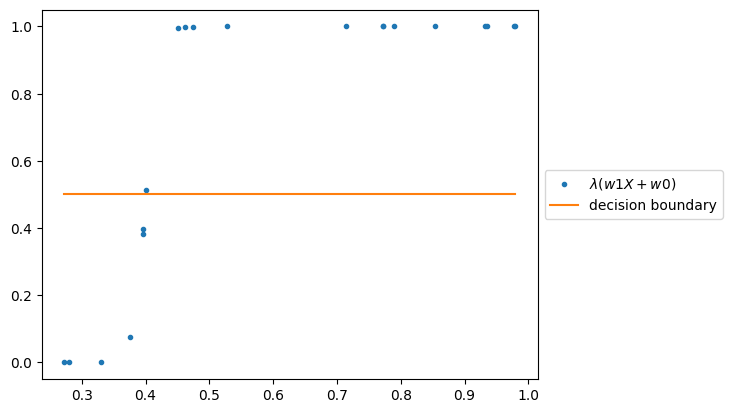

In [3]:
# really basic classifier function, commonly used
def logistic(z): return 1/(1+np.exp(-z))

# test our implementation
w = [-40, 100] #Task change these

plt.plot(X,logistic(w[1]*X+w[0]),'.',label='$\lambda(w1 X+ w0)$') 
plt.plot([min(X), max(X)],[0.5, 0.5],'-',label='decision boundary') 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)); plt.show();

The above can only classify based on a linear relationship between the inputs and classes, so cannot capture (in this example) inputs of 0.9 being class 0 again.

The GP can model non-linear input-class relationships, where the flexibility of the decision boundary can be determined through the covariance matrix $\mathbf{K}$, which we can model using a radial basis function (RBF) kernel:

\begin{align}
K(\mathbf{x},\mathbf{x}') &=& \sigma^2_f \exp\left(-\frac{(\mathbf{x} - \mathbf{x}')^T(\mathbf{x} - \mathbf{x}')}{2l^2}\right)
\end{align}

which has Kernel parameters $\Theta$ $=[\sigma_f, l]$
- $\sigma_f$: limiting standard deviation magnitude of the prediction uncertainty
- $l$: Length scale

**Task:** Changing kernel parameters and visualise the impact on the covariance matrix, [$\sigma_f$, l]=[0.1, 1], [0.4, 1], [0.4, 10], 

The inputs values X have the shape  (20, 1)
The covariance matrix K has the shape  (10, 10)
With l =  1 and sigma_f = 0.1


Text(0.5, 1.0, 'Covariance matrix')

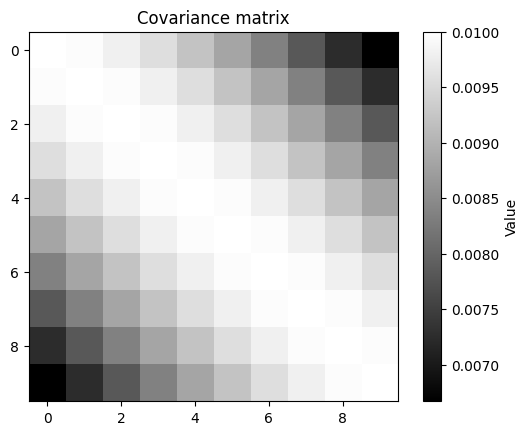

In [4]:
def rbf_kernel(X1, X2, theta):
    """
    Radial Basis Function.
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).
        phi: Kernel weight parameters 
                - theta[0]= sigma_f
                - theta[1]= length scale along input axis
    Returns:
        (m x n) matrix
    """

    X1_sq = np.sum(X1**2, axis=1, keepdims=True)  # (m, 1)
    X2_sq = np.sum(X2**2, axis=1, keepdims=True).T  # (1, n)
    dist_sq = X1_sq - 2 * X1 @ X2.T + X2_sq
    return theta[0] ** 2 * np.exp(-dist_sq/ (2* theta[1] ** 2))

# uniform array
x = np.arange(0, 1, 0.1)[:,None] #this makes it a column vector

# test our implementation
l = 1; sigma_f = 0.1 #Task change these
K=rbf_kernel(x,x,[sigma_f, l]);

print('The inputs values X have the shape ',X.shape)
print('The covariance matrix K has the shape ',K.shape)
print('With l = ',l, 'and sigma_f =', sigma_f)

plt.imshow(K, cmap='gray')
plt.colorbar(label='Value')
plt.title('Covariance matrix')


### Optimise Function Parameters

We calculate the GP function using the following optimisation

__Posterior_ **input:** $\mathbf{K}$ (covariance matrix), $\mathbf{c}$ (classification targets)
> $\mathbf{f}=0$ #initialisation
>
> while $\mathbf{f}-\mathbf{f}_{\text{prev}}$ > Threshold
>
> > $W = \lambda(\mathbf{f})(1-\lambda(\mathbf{f}))$
> >
> > $\mathbf{L} = \text{Cholesky}(I+W^{\frac{1}{2}}\mathbf{K}W^{\frac{1}{2}})$
> >
> > $\mathbf{b} = W\mathbf{f} + (\mathbf{c}-\lambda(\mathbf{f}))$
> >
> > $\mathbf{a} = \mathbf{b} - W^{\frac{1}{2}}(\mathbf{L}^T \backslash (\mathbf{L} \backslash W^{\frac{1}{2}}\mathbf{K}\mathbf{b}))\hspace{.5cm}$   # where \ indicates solving the Cholesky lower triangle via substitution
> >
> > $\mathbf{f} = \mathbf{K}\mathbf{a}\hspace{4.8cm}$ # posterior
>
> $\log q(\mathbf{c}|\mathbf{X},\theta) = -\dfrac{1}{2} {\mathbf{a}}^T \mathbf{f} - \sum_i \log(1+\exp(\mathbf{f_i})) + \mathbf{c}^T\mathbf{f} - \sum_i \log L_{ii}\hspace{0.5cm}$ # negative log likelihood

**return:** $\hat{\mathbf{f}}$ (posterior), $\log q(\mathbf{c}|\mathbf{X},\theta)$ (variance) (approx. log marginal likelihood)

Below we implement $\mathbf{K}$ which adds a small amount of measurement noise to RBF kernel diagonal elements to aid numerical stability. The negative log likelihood (below) needs to be solved iteratively using a numerical optimiser to find the optimal model variables $\theta$.

In [5]:
def K_(X, theta, sigma_n=1e-5):
    """Adds noise to the diagonal elements of the kernel"""
    return rbf_kernel(X, X, theta) + sigma_n * np.eye(len(X))

def W_(f):
    """W is a diagonal matrix with elements (logistic(f)(1-logistic(f)))"""
    W = Matrix(len(f),len(f))

    for i in range(len(f)): 
        W[i,i] = logistic( f[i]) * ( 1 - logistic(f[i]) )
    return W

def posterior(X, c, K, max_iter=10, tol=1e-9):
    """
    Computes the mode of posterior p(a|t).
    """
    f = Vector(len(c)) #zeros    
    I = np.eye(len(X))    
  
    for i in range(max_iter):
        W = W_(f)

        L = np.linalg.cholesky( I + np.sqrt(W) @ K @ np.sqrt(W) )
        
        b = W.dot(f) + (c - logistic(f))    
        a = b - np.sqrt(W) @ np.linalg.solve(L.T,(np.linalg.solve(L, np.sqrt(W) @ K @ b)))
                                 
        f_new = K @ a

        # update function
        f_diff = np.abs(f_new - f)
        f = f_new

        # check for convergence
        if not np.any(f_diff > tol):
            break

    return f, L

def negative_log_likelihood_fn(X, c):
    """
    Returns the negative log-likelihood function for data X, c.

    Basically: given our classes and inputs, how likely are these classes -> its a performance metric of this description of the inputs
    """
    def negative_log_likelihood(theta):
        K = K_(X, theta)
        K_inv = np.linalg.inv(K)
        
        # posterior mode depends on theta (via K)    
        f, L = posterior(X, c, K)     

        # first term, since f=Ka
        ll = - 0.5 * f.T.dot(K_inv).dot(f)

        # second term
        sum_pcf = 0            
        for i in range(len(f)): 
            sum_pcf += np.log(1.0 + np.exp(f[i])) 
            
        # third term
        sum_diag_logL = 0        
        for i in range(len(L)): 
            sum_diag_logL += np.log( L[i,i] )
        
        ll += - sum_pcf  + c.T.dot(f) - sum_diag_logL
        
        return -ll

    return negative_log_likelihood

Below we optimise the GP kernel parameters using the synthetic training data ($X$, $z$) generated earlier, and visualise the covariance matrix. This adjusts both the mean function (posterior) and the covariance matrix.

C:\Users\skyem\AppData\Local\Temp\ipykernel_30368\588454238.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  W[i,i] = logistic( f[i]) * ( 1 - logistic(f[i]) )


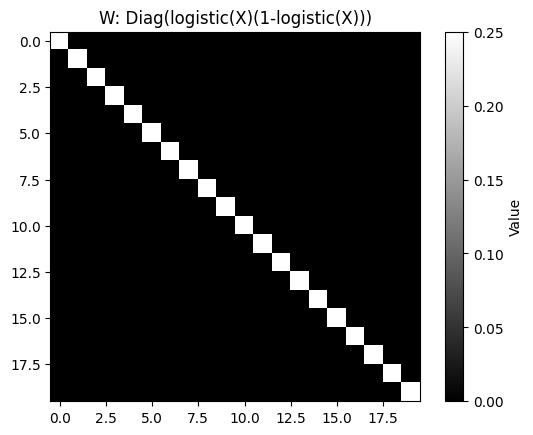

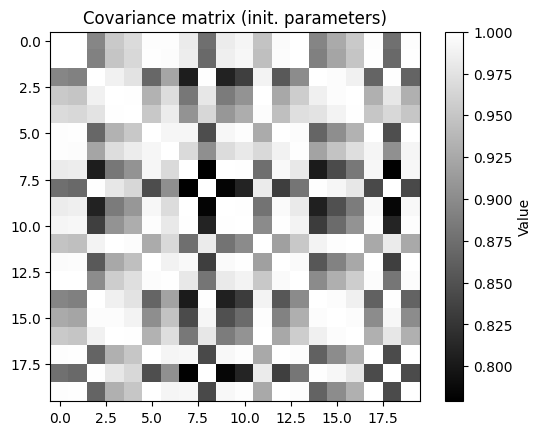

Optimized theta [\sigma_f, l] = [0.100, 6.704], negative log likelihood = 13.883


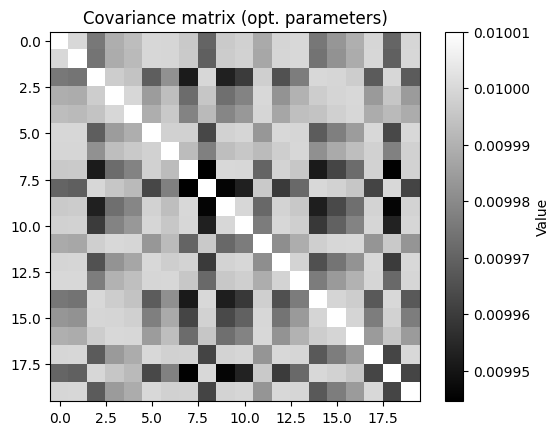

In [6]:
from scipy.optimize import minimize

f = Vector(len(X)) #mean function is just 0 to start with

plt.imshow(W_(f), cmap='gray')
plt.colorbar(label='Value')
plt.title('W: Diag(logistic(X)(1-logistic(X)))')
plt.show()

l = 1; sigma_f = 1
theta = [sigma_f, l]
plt.imshow(K_(X,theta), cmap='gray')
plt.colorbar(label='Value')
plt.title('Covariance matrix (init. parameters)')
plt.show()

# calculate the posterior
posterior(X, z, K_(X,theta), max_iter=100, tol=1e-9)

res = minimize(negative_log_likelihood_fn(X, z), theta,
               bounds=((1e-1, None), (1e-1, None)),
               method='L-BFGS-B')
theta = res.x

print(f'Optimized theta [\sigma_f, l] = [{theta[0]:.3f}, {theta[1]:.3f}], negative log likelihood = {res.fun:.3f}')

plt.imshow(K_(X,theta), cmap='gray')
plt.colorbar(label='Value')
plt.title('Covariance matrix (opt. parameters)')
plt.show()

### Predict Classes of New Data

The trained GPC can be used to predict classes together with the prediction uncertainty for new data, by applying the covariance $\mathbf{K}$ and mean functions $\mathbf{f}$ to the test data, where the distance between test inputs and training inputs $\mathbf{K}_*=K(\mathbf{X},\mathbf{X}_*)$ and variance of the test inputs $\mathbf{K}_{**}=K(\mathbf{X}_*,\mathbf{X}_*)$ are considered.

__Predicted Class__ **input:** $\bar{\mathbf{f}}$ (posterior), $\mathbf{X}$ (inputs), $\mathbf{c}$ (classification targets), $\mathbf{K}$ (covariance function), $p(\mathbf{c}|\mathbf{f})$ (likelihood function), $\mathbf{x}_*$ (prediction input)

> $W =  \lambda(\mathbf{f})(1-\lambda(\mathbf{f}))$
>
> $\mathbf{L} = \text{Cholesky}(I+W^{\frac{1}{2}}\mathbf{K}W^{\frac{1}{2}})$
>
> $\mathbf{f}_* = \mathbf{K}_*^{T}(\mathbf{c}-\lambda)$
>
> $\mathbf{v} = L \backslash
 (W^{\frac{1}{2}}\mathbf{K}_*) \hspace{2.2cm}$ # where \ indicates solving the Cholesky lower triangle via substitution
>
> $\sigma^2_{\mathbf{f}_*}= \mathbf{K}_{**}-\mathbf{v}^T\mathbf{v} \hspace{2.2cm}$ # variance of predicted values, i.e., diagonal elements
>
> $\kappa = (1 + 0.25\pi \sigma^2_{\mathbf{f}_*})^{-1} \hspace{1.4cm}$ # MacKay's approximation
>
> $\hat{\mathbf{c}}_{*} = \lambda(\mathbf{f}_* \kappa^{0.5})$

**return:** $\hat{\mathbf{c}}_{*}$ (predicted class)

In [7]:
def predict_f(X_test, X, c, theta):
    """
    Computes the mean and variance of logits at points X_test
    given training data X, t and kernel parameters theta.
    """
    K = K_(X, theta)
    K_s = rbf_kernel(X, X_test, theta)
    
    f, L = posterior(X, c, K)    
    W = W_(f)        
    
    f_test_mu = (K_s.T.dot(c - logistic(f)))

    # Compute variances from the cholesky decomposisiotn, only need diagonals
    v = np.linalg.solve(L, np.sqrt(W) @ K_s)  
    
    # Column vector of diagonal elements
    f_test_var = np.diag((K_(X_test, theta) - v.T.dot(v)))[:,None] #[:,None] reshapes into a column vector  

    return f_test_mu, f_test_var    

def predict_class(X_test, X, c, theta):
    """
    Computes the probability of c=1 at points X_test
    given training data X, t and kernel parameters theta.
    """
    f_mu, f_var = predict_f(X_test, X, c, theta)

    kappa = 1/(1+0.25*np.pi* f_var)
    return logistic( f_mu * np.sqrt( kappa ) )

We can make our class prediction and visualise the impact of the uncertainty

C:\Users\skyem\AppData\Local\Temp\ipykernel_30368\588454238.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  W[i,i] = logistic( f[i]) * ( 1 - logistic(f[i]) )


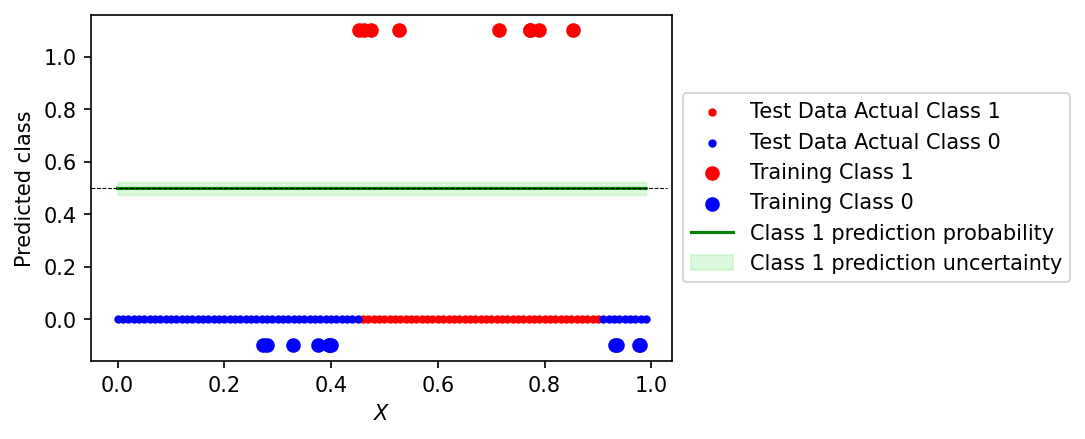

In [8]:
from plot_feeg6043 import plot_gpc

# mean class prediction
c_mean = predict_class(X_test, X, z, theta)

z_predict = Vector(len(c_mean))
decision_boundary = 0.5

# binarise the example
for i in range(len(c_mean)): 
    if c_mean[i] > decision_boundary: z_predict[i]=1
    else: z_predict[i]=0

# visualise the uncertainty
f_mu, f_var = predict_f(X_test, X, z, theta)
kappa = 1/(1.0 + np.pi * f_var / 8 )
c_upper = logistic((f_mu+np.sqrt(f_var)) * np.sqrt(kappa))
c_lower = logistic((f_mu-np.sqrt(f_var)) * np.sqrt(kappa))

plot_gpc([X_test, z_predict, class_1_test, class_0_test], 
         posterior = [c_mean, 'Class 1 prediction probability'],
         posterior_uncert = [c_upper, c_lower],
         training = [X,z,class_0,class_1])

## <span style="color:red"> 2. Classification with GaussianProcessClassifier in sklearn </span>

### <span style="color:red"> 1D data </span> 

We compare the implemented approach with the `GaussianProcessClassifier` (GPC) in sklearn. Results may differ slightly as the `sklearn` implementation is less susceptable to finding a local minimum, but the overall results should be similar.

In [9]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

# set the gpc kernel as the rbf kernel
rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpc = GaussianProcessClassifier(kernel=rbf,random_state=0)

# fit the training data
gpc.fit(X, z[:,0])

# Obtain optimized kernel parameters
sklearn_theta_1 = gpc.kernel_.k2.get_params()['length_scale']
sklearn_theta_0 = np.sqrt(gpc.kernel_.k1.get_params()['constant_value'])

print(f'Optimized theta [\sigma_f, l]= [{sklearn_theta_0:.3f}, {sklearn_theta_1:.3f}], negative log likelihood = {-gpc.log_marginal_likelihood_value_:.3f}')

Optimized theta [\sigma_f, l]= [0.003, 1.186], negative log likelihood = 13.863


C:\Users\skyem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


We compare the sklearn library output with our own implementation

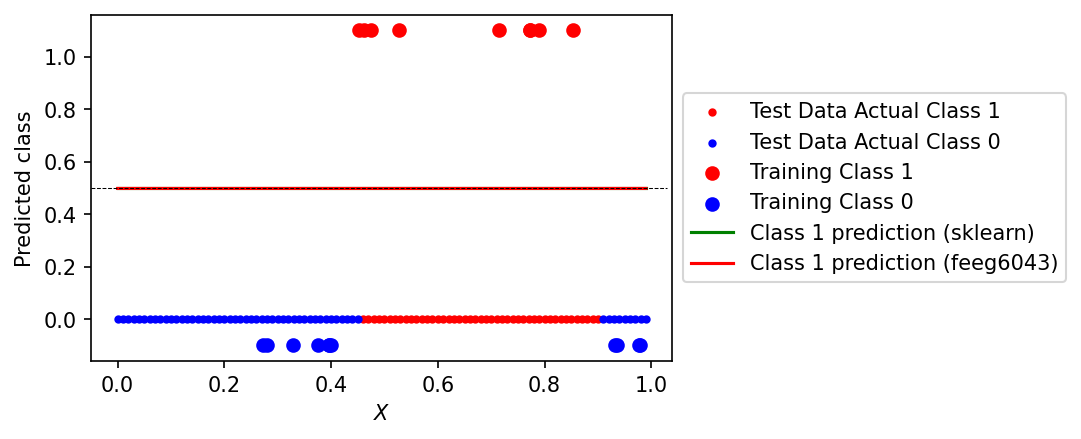

In [10]:
c_mean_sklearn = gpc.predict_proba(X_test)[:,1] #[:,1] is class 1 probability
z_sklearn = gpc.predict(X_test)[:,None] # is the class prediction (uses a decision boundary of 0.5)

# plot the data
plot_gpc([X_test, z_sklearn, class_1_test, class_0_test], 
         posterior = [c_mean_sklearn, 'Class 1 prediction (sklearn)'], 
         posterior_compare = [c_mean, 'Class 1 prediction (feeg6043)'], 
         training = [X,z,class_0,class_1])

Unfortunately, `sklearn` does not provide access to prediction uncertainties when using GPCs. Other libraries do, but are not part of the standard python installation. We can however, use the optimised kernel parameters in our own implementation to recover uncertainty. This can be extended to higher dimensional data.

C:\Users\skyem\AppData\Local\Temp\ipykernel_30368\588454238.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  W[i,i] = logistic( f[i]) * ( 1 - logistic(f[i]) )


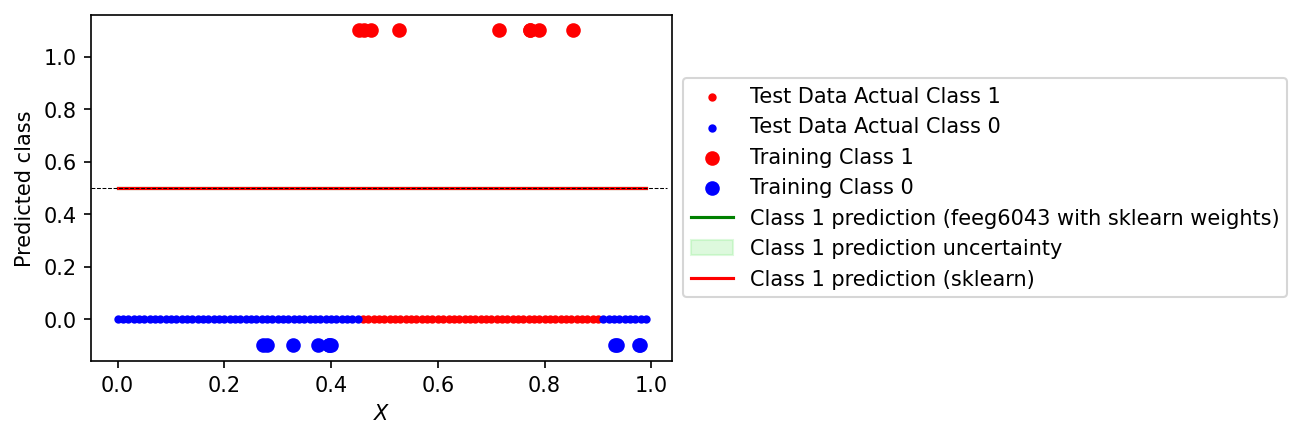

In [11]:
# use our own function with sklearn determined weights
theta_sk = [sklearn_theta_0, sklearn_theta_1]
c_mean_feeg6043_sklearn = predict_class(X_test, X, z, theta_sk)

z_predict = Vector(len(c_mean_feeg6043_sklearn))
decision_boundary = 0.5

# binarise the example around the decision boundary
for i in range(len(c_mean_feeg6043_sklearn)): 
    if c_mean_feeg6043_sklearn[i] > decision_boundary: z_predict[i]=1
    else: z_predict[i]=0

# visualise the uncertainty
f_mu, f_var = predict_f(X_test, X, z, theta_sk)
kappa = 1/(1.0 + np.pi * f_var / 8 )
c_upper = logistic((f_mu+np.sqrt(f_var)) * np.sqrt(kappa))
c_lower = logistic((f_mu-np.sqrt(f_var)) * np.sqrt(kappa))

plot_gpc([X_test, z_predict, class_1_test, class_0_test], 
         posterior = [c_mean_feeg6043_sklearn, 'Class 1 prediction (feeg6043 with sklearn weights)'],
         posterior_compare = [c_mean_sklearn, 'Class 1 prediction (sklearn)'],         
         posterior_uncert = [c_upper, c_lower],
         training = [X,z,class_0,class_1])

Due to differences in implementation details, results are not identical, but are very similar and allow prediction uncertainty to be estimated.

# <span style="color:red"> Classification of Lidar data </span>

GPC can be used to classify 2D range and bearing observations. To do this we simulate a 2D environment and use the RangeAngleKinematics class to simulate observations in it.

We then train a GPC to recognise objects (corner) in our surroundings. We further extract a landmark (corner inflection point) on observations that have been classified as such, so that these can be used as a landmark, e.g., for navigation improvement or some behavioural response. A similar process could be used to identify a circle or any other shape for use in robotic decisions.

##  <span style="color:red">Simulating the environment</span>

We first build a simple map environment that the robot can move in and observe. 

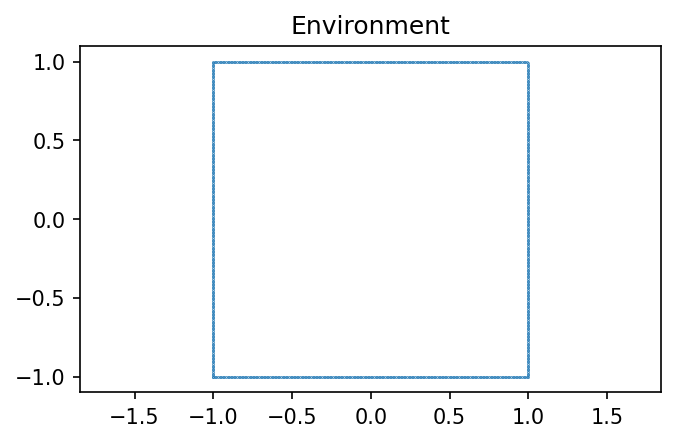

In [12]:
from math_feeg6043 import polar2cartesian, cartesian2polar, HomogeneousTransformation, l2m
from plot_feeg6043 import show_observation

# simulate and environment
m_x = []
m_y = []

for x in np.arange(-1, 1, 0.01):
    m_x.append(x)
    m_y.append(-1) #west wall      
for x in np.arange(-1, 1, 0.01):
    m_x.append(x)
    m_y.append(1) #east wall
for y in np.arange(-1, 1, 0.01):
    m_x.append(-1)
    m_y.append(y) #south wall
for y in np.arange(-1, 1, 0.01):
    m_x.append(1)
    m_y.append(y) #north wall

environment_map = l2m([m_x,m_y])

# Create a scatter plot
plt.figure()
plt.scatter(m_x, m_y,s=0.1)
plt.axis('equal')
plt.title('Environment')
plt.show()    

##  <span style="color:green">Simulating sensing</span>

**Sensing:** A scanning range angle lidar is simulated using methods covered in A1.3, extended to generate range proportional noise on the measurements. 

We implement the following functions:
- **lidar_scan:** Simulates a lidar scan given a pose, environment and lidar parameters and defined measurement noise 
- **plot_scan:** Plots the observations, FOV and pose of the robot
- **find_corner:** find the corner inflection point in a lidar scan
- **GPC_input_output:** a class to store lidar scans and labels for use in a gpc - this fills any nans and zero offsets about the mean and can accomodate a representative location

In [13]:
from model_feeg6043 import RangeAngleKinematics, t2v, v2t
from plot_feeg6043 import plot_2dframe
import copy

def lidar_scan(p_eb, environment_map, lidar, sigma_observe):
    """ Gets observations from the robot pose and the map.
    
    Parameters
    -----------
    p_eb = [3 x 1] Vector of floats
        The robot pose in the e frame as
            [[x
              y
              gamma]]
    environment_map = [l x 2] Matrix of floats
        A list observable element in the robots surroundings
        where each element is a transposed 2x1 vector of x, y coordinates in the environment frame
            [[x
              y]].T
    lidar = RangeAngleKinematics class
        A member of the RangeAngleKinematics that determines sensor properties
        range [min, max] in metres, and scan_fov in radians
        e.g., RangeAngleKinematics(x_bl, y_bl, distance_range = [0.1, 1], scan_fov = np.deg2rad(90)) 
        
    sigma_observe = [2 x 2] Matrix of floats
        Observation model for linear noise with range
        [[sigma_xr sigma_xtheta]
         [sigma_yr sigma_ytheta]]
        
    Returns
    -------
    observations: [n_beams x 2] Matrix of floats
        The observations as an array of (range, bearing) points. 
    observations_std: [n_beams x 1] Matrix of floats
        The observations set as an array of (range_std, bearing) points.         
    """

    m_range = [] # range and bearing to map elements
    m_bearing = []    
    
    z_range = [] # range and bearing measurements (resamples at resolution and with some noise)
    z_range_std = [] # range and bearing measurements (resamples at resolution and with some noise)
    z_bearing = []        
    
    for i in range(len(environment_map)):
        t_em = environment_map[[i],:].T
        z_lm, sigma_rtheta, t_lm, sigma_xy = lidar.loc_to_rangeangle(p_eb, t_em, sigma_observe)
        m_range.append(z_lm[0])
        m_bearing.append(z_lm[1])   
       
    #sampling the map
    bearing_resolution = np.linspace(-lidar.scan_fov/2,lidar.scan_fov/2,lidar.n_beams)

    #picks the nearest map entity and adds range based noise. Bearing noise is simulated to be half the beam width (i.e., (fov/n_beams)) 
    for theta in bearing_resolution:        
        if ~np.all(np.isnan(m_bearing)):
            i = np.nanargmin(abs((theta -m_bearing)))
        
            if abs(theta - m_bearing[i]) < lidar.scan_fov/(2*lidar.n_beams):
                z_range.append(m_range[i]+np.random.normal(0,m_range[i]*sigma_observe[0,0],1))
                z_range_std.append(abs(m_range[i]*sigma_observe[0,0]))
                z_bearing.append(theta)
            else:
                z_range.append(np.nan)
                z_range_std.append(np.nan)
                z_bearing.append(theta)
        else:
            z_range.append(np.nan)
            z_range_std.append(np.nan)
            z_bearing.append(theta)
   
    observations = l2m([z_range,z_bearing]) 
    observations_std = l2m([z_range_std, z_bearing]) 
    
    return observations, observations_std


def show_scan(p_eb, lidar, observations, show_lines = True):
    """ Plots observations, field of view and robot pose
    """

    ######################## Calculate FOV    
    range_max = lidar.distance_range[1]
    range_min = lidar.distance_range[0]    
    fov = lidar.scan_fov
        
    r_ = []
    theta_ = []    
    
    # for field of view
    theta = np.linspace(-fov / 2, fov / 2, 30)    
        
    for i in theta:
        r_.append(range_max)
        theta_.append(i)        
    for i in reversed(theta):
        r_.append(range_min)
        theta_.append(i)    
    r_.append(range_max)
    theta_.append(-fov/2)

    fov = l2m([r_,theta_])
    ######################## Plot the FOV        
    
    t_lm = Vector(2) # lidar frame measurement placeholder    
    t_em = Vector(2) # environment frame measurement
    
    fov_x = []
    fov_y = []

    H_eb = HomogeneousTransformation(p_eb[0:2],p_eb[2])
        
    for z_fov in fov:    
        t_lm[0],t_lm[1] = polar2cartesian(z_fov[0],z_fov[1])      
        t_em = t2v((H_eb.H@lidar.H_bl.H)@v2t(t_lm))
    
        fov_x.append(t_em[0])
        fov_y.append(t_em[1])  
        
    if show_lines == True: plt.plot(fov_y, fov_x,'orange')

    if len(observations) != 0:            
        for z_lm in observations:    
            t_lm[0],t_lm[1] = polar2cartesian(z_lm[0],z_lm[1])
            show_observation(H_eb,t2v(lidar.H_bl.H@v2t(t_lm)),Matrix(2,2),None,ax, show_lines)        
        
    else:        
        cf=plot_2dframe(['pose','b','b'],[H_eb.H,H_eb.H],False,False)
        
    plt.xlabel('Eastings, m')
    plt.ylabel('Northings, m')
    plt.axis('equal')

def find_corner(corner, threshold = 0.01):
    # identify the reference coordinate as the inflection point
    
    # Step 1: Compute slope
    slope = np.gradient(corner.data[:, 0])
    
    # Step 2: Compute the second derivative (curvature)
    curvature = np.gradient(slope)
    
    # Step 3: Check if criteria is more than threshold    
    print('Max inflection value is ',np.nanmax(abs(np.gradient(np.gradient(curvature)))), ': Threshold ',threshold)
    if np.nanmax(abs(np.gradient(np.gradient(curvature)))) > threshold:
        # compute index of inflection point    
        largest_inflection_idx = np.nanargmax(abs(np.gradient(np.gradient( curvature ))))
        
        r = corner.data[largest_inflection_idx, 0]  # Radial distance at the largest curvature
        theta = corner.data[largest_inflection_idx, 1]  # Angle at the largest curvature
        return r, theta, largest_inflection_idx
    
    else:
        return None, None, None  # No inflection points found

class GPC_input_output:
    def __init__(self, data, label):
        """
        Initializes an observation with data and a label.

        Parameters:
        data (matrix): The observation data (e.g., a matrix).
        data_filled (matrix): The observation data after zero offset and making nan's mean
        label (str): The label associated with the observation.
        ne_representative: representative northings and eastings location
        """
        self.data = data
        self.data_filled = self._fill_nan(data)
        self.label = label
        self.ne_representative = None 
        # make filled and zero offset version        
        
    def _fill_nan(self,data):
        data_filled = np.copy(data)
        mean=np.nanmean(data[:,0])  
        for i in range(len(data[:,1])):
            if np.isnan(data[i,0]):
                data_filled[i,0]=0
            else: 
                data_filled[i,0]=data[i,0]-mean
        return data_filled

We define a lidar and extend our model in A1.3 to define a number of beams.

In [14]:
######################## Observation model ##################
# locate lidar on robot (keep it simple)
x_bl = 0; y_bl = 0
t_bl = Vector(2)
t_bl[0] = x_bl
t_bl[1] = y_bl
H_bl = HomogeneousTransformation(t_bl,0)

# use Class from A1.3
lidar = RangeAngleKinematics(x_bl, y_bl, distance_range = [0.1, 1], scan_fov = np.deg2rad(60), n_beams = 30)
#################################################################

*******************************************************************************************
Sensor located at: [0.] [0.] m offset, at angle: 0.0 deg to the body
Measurement range is between: [0.1, 1] m
Scanning field of view is: 59.99999999999999 deg
Number of beams per scan is: 30
*******************************************************************************************


Simlulate a scan for a specified robot pose with some measurement uncertainty (random sampled from a distribution)

3x1 state vector:
 [[-0.7       ]
 [-0.1       ]
 [ 4.71238898]] 

2x2 measurement noise model:
 [[0.01       0.        ]
 [0.00174533 0.        ]] 



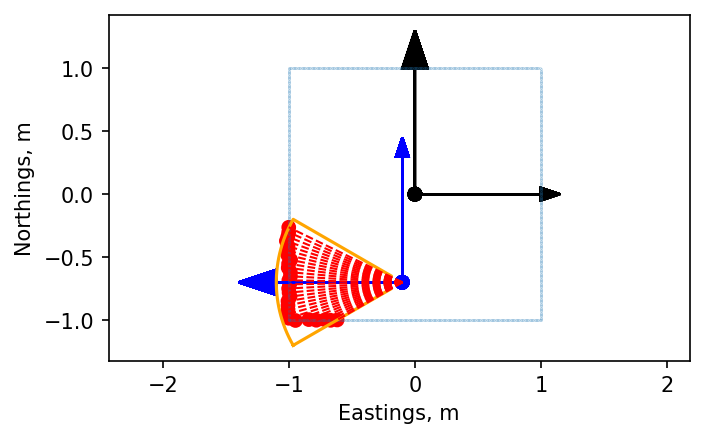

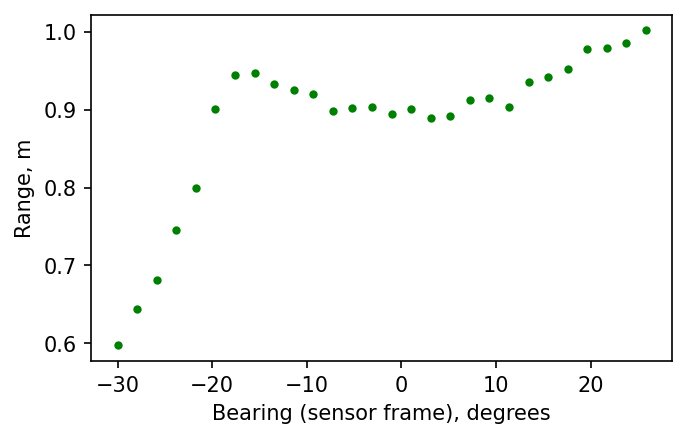

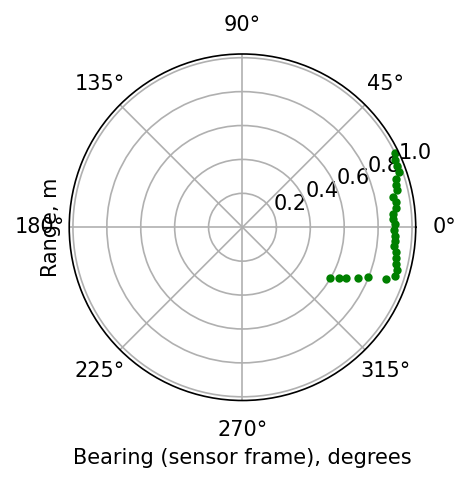

In [15]:
######################## Set the robot pose b in the e frame ##################
p = Vector(3); 

p[0] = -0.7 #Northings
p[1] = -0.1 #Eastings
p[2] = np.deg2rad(270) #Heading (rad)
print('3x1 state vector:\n',p,'\n')
H_eb = HomogeneousTransformation(p[0:2],p[2])
#############################################################################

#########observation model linear noise with range###############
sigma_observe = Matrix(2,2)
sigma_observe[0,0] = 0.01 #1% of range
sigma_observe[0,1] = 0
sigma_observe[1,0] = np.deg2rad( 0.1 ) #0.1 degree per metre range
sigma_observe[1,1] = 0
print('2x2 measurement noise model:\n',sigma_observe,'\n')
#############################################################################

# compute observations with noise
observation, _ = lidar_scan(p, environment_map, lidar, sigma_observe)

# plot scan in the environment frame
fig,ax = plt.subplots()
show_scan(p, lidar, observation)
ax.scatter(m_y, m_x,s=0.01)
plt.show()

# plot the raw sensor readings in cartesian coordinates
plt.plot(np.rad2deg(observation[:, 1]), observation[:, 0], 'g.', label='Observations')
plt.xlabel('Bearing (sensor frame), degrees')
plt.ylabel('Range, m')
plt.show()

# plot the raw sensor readings in polar coordinates
plt.polar(observation[:, 1], observation[:, 0], 'g.', label='Observations')  # Create polar plot
plt.xlabel('Bearing (sensor frame), degrees')
plt.ylabel('Range, m')
plt.show()

We can see this is a corner, and can use this as a classification template for corner landmarks for training later. Below we: 
- Store the measurement as a corner landmark
- Identify a reference coordinate (point of inflection) to use as the landmark's coordinate

Max inflection value is  0.021385090127029792 : Threshold  0.01
Map observation made at, Northings =  [-0.98539679] m, Eastings = [-1.00043671] m


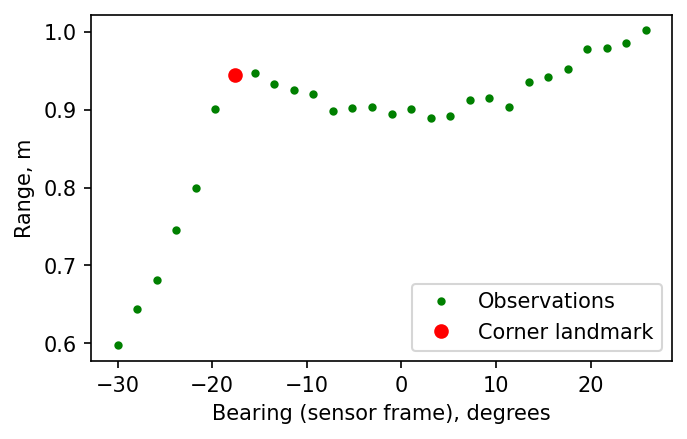

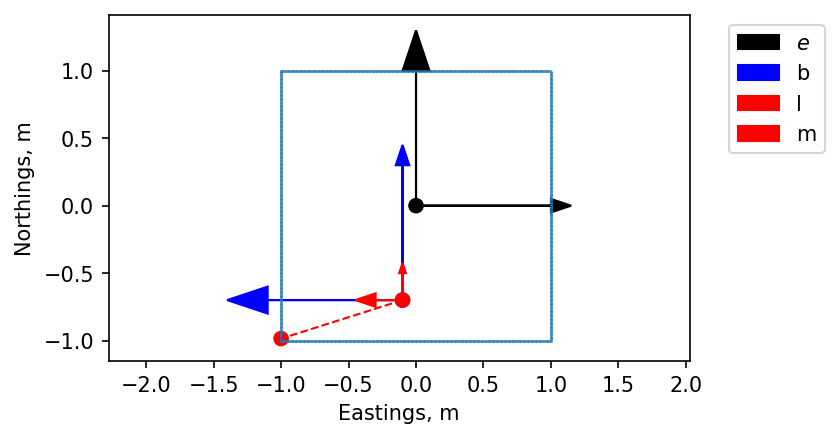

In [16]:
# store the data as an example of a 'corner' (label)
corner_example = GPC_input_output( observation, 'corner' )

# run a bespoke corner detection algorithm (not GPC) to find a corner and return the inflection point as a landmark
z_lm = Vector(2)
z_lm[0], z_lm[1], loc = find_corner(corner_example)

# update the landmark locations 
corner_example.ne_representative = lidar.rangeangle_to_loc(p,z_lm)
print('Map observation made at, Northings = ',corner_example.ne_representative[0],'m, Eastings =',corner_example.ne_representative[1],'m')


# plot the raw sensor readings
plt.plot(np.rad2deg(observation[:, 1]), observation[:, 0], 'g.', label='Observations')
plt.plot(np.rad2deg(observation[loc, 1]), observation[loc, 0], 'ro', label='Corner landmark')
plt.xlabel('Bearing (sensor frame), degrees')
plt.ylabel('Range, m')
plt.legend()
plt.show()

# Show the landmark in the e-frame
H_el = HomogeneousTransformation()
H_el.H = H_eb.H@lidar.H_bl.H

# use the plot_2dframe function in plot_feeg6043
plot_2dframe(['observation','b','l','m'],[H_eb.H,H_el.H,z_lm],True)
plt.scatter(m_x, m_y,s=0.1)
plt.axis('equal')
plt.show()

##  <span style="color:green">Generate training data</span>

Create a database of corners around this point to use for training, using the bespoke corner detector to check before adding them to the GPC training database. This should be conservative as we want to make sure the training data is error free

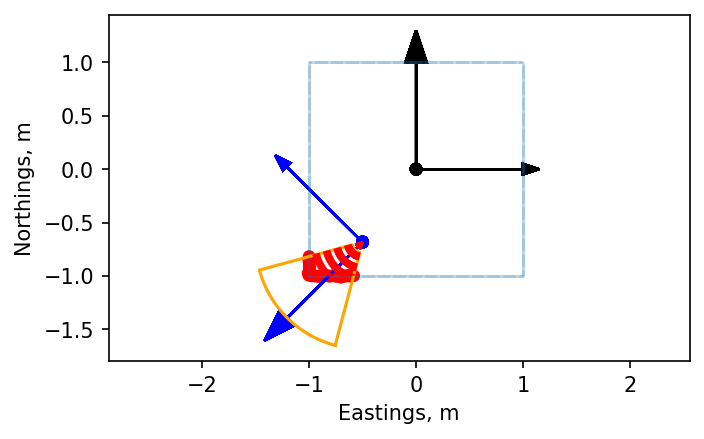

Max inflection value is  0.011470823178462687 : Threshold  0.007
Map observation made at, Northings =  [0.5904721] m, Eastings = [0.23471669] m


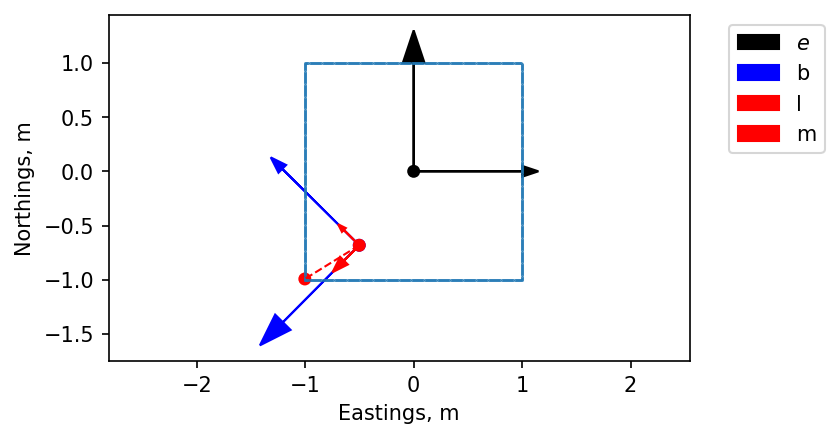

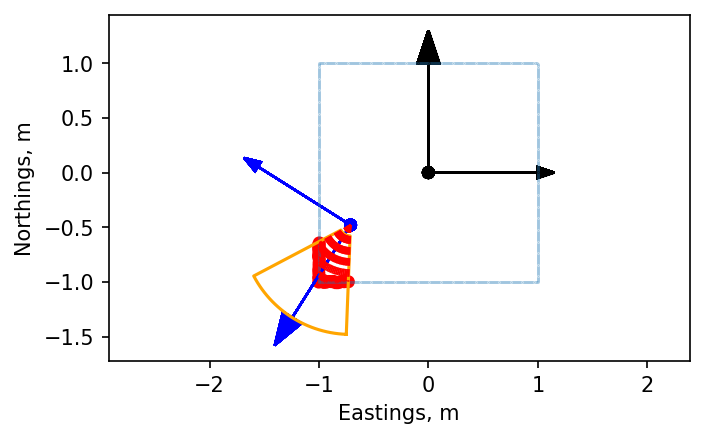

Max inflection value is  0.011291902828480027 : Threshold  0.007
Map observation made at, Northings =  [0.59695755] m, Eastings = [-0.05416539] m


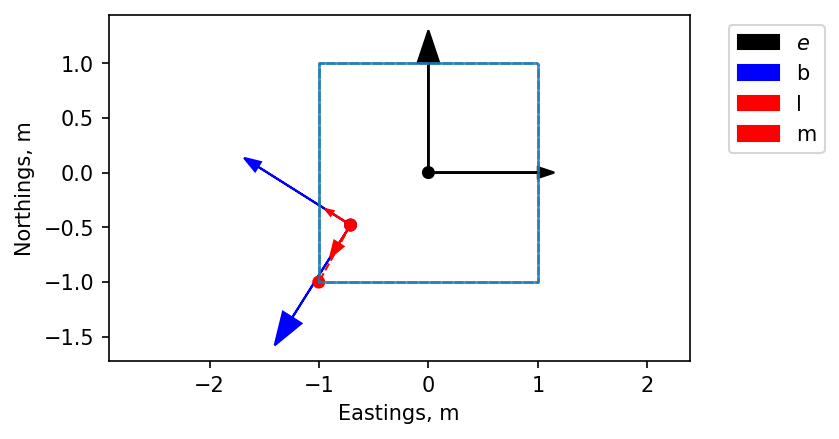

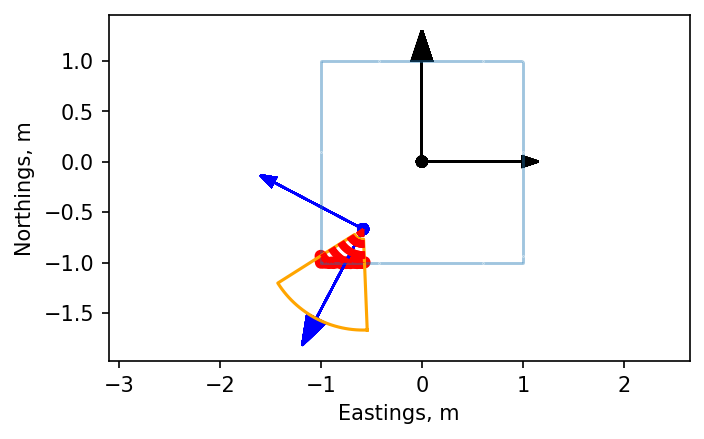

Max inflection value is  0.01007824843777684 : Threshold  0.007
Map observation made at, Northings =  [0.53294004] m, Eastings = [0.41526799] m


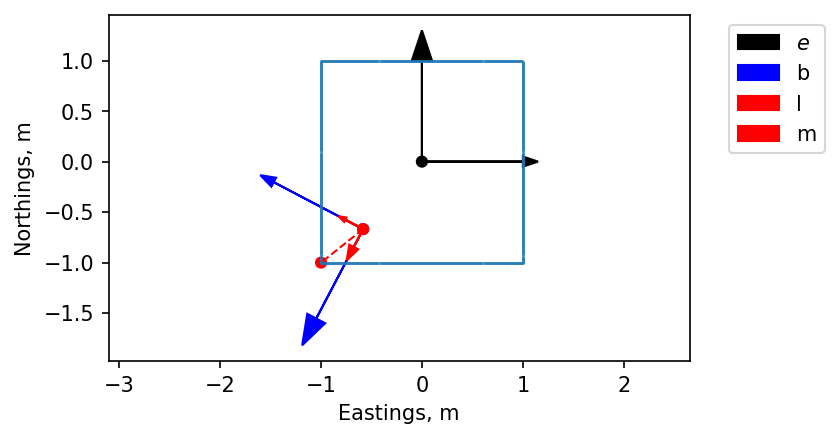

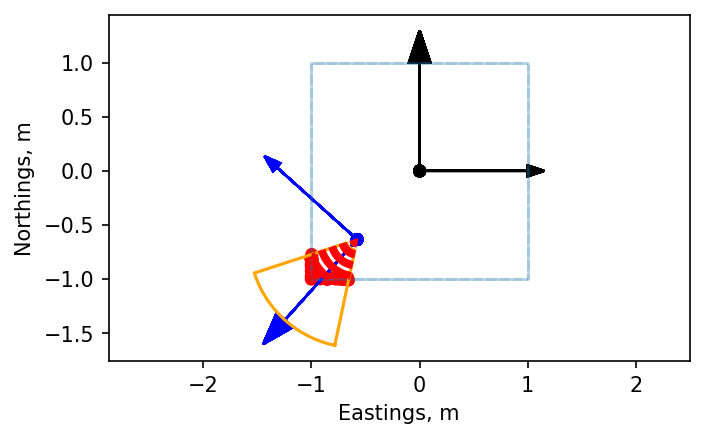

Max inflection value is  0.013331293584836115 : Threshold  0.007
Map observation made at, Northings =  [0.56137728] m, Eastings = [0.12638591] m


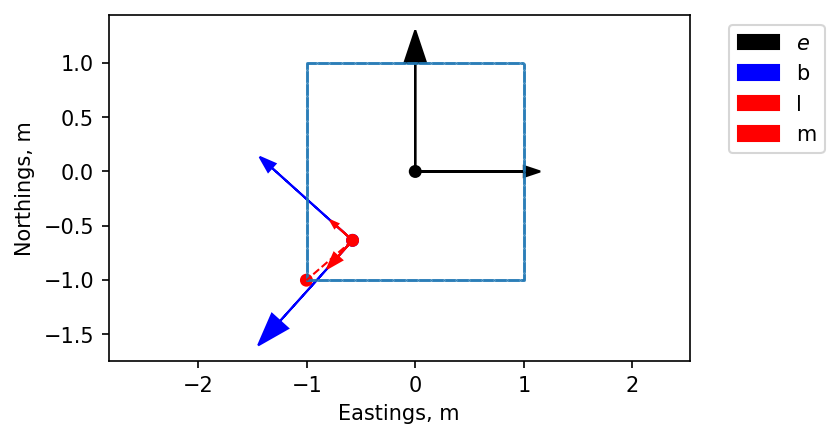

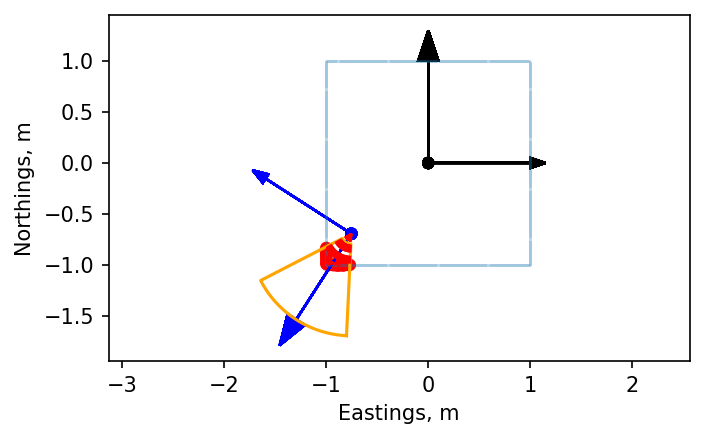

Max inflection value is  0.0043924421991850746 : Threshold  0.007


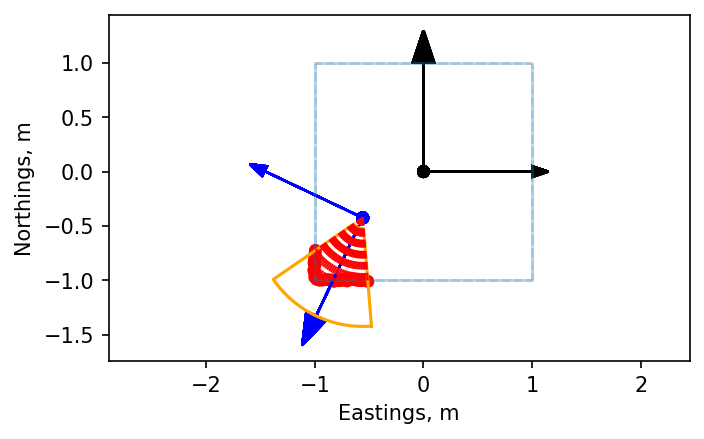

Max inflection value is  0.005885796417406969 : Threshold  0.007


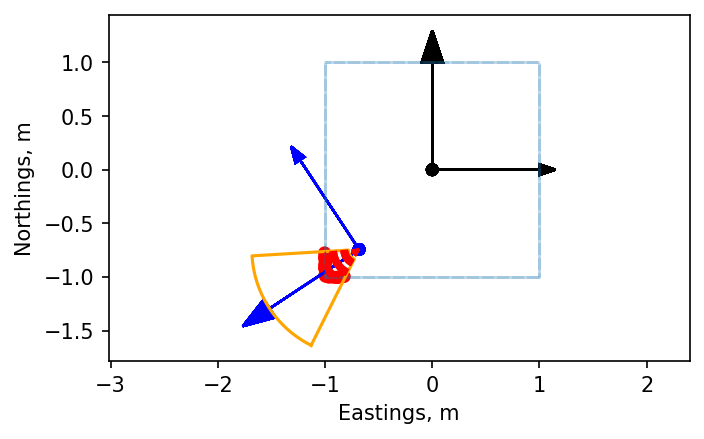

Max inflection value is  0.005221210635521726 : Threshold  0.007


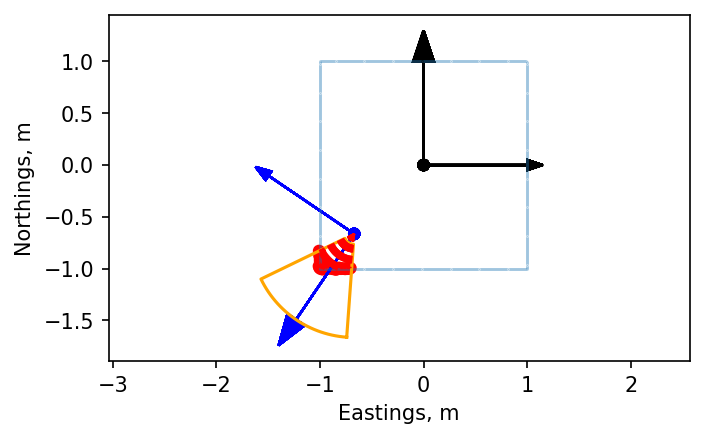

Max inflection value is  0.005854905888020789 : Threshold  0.007


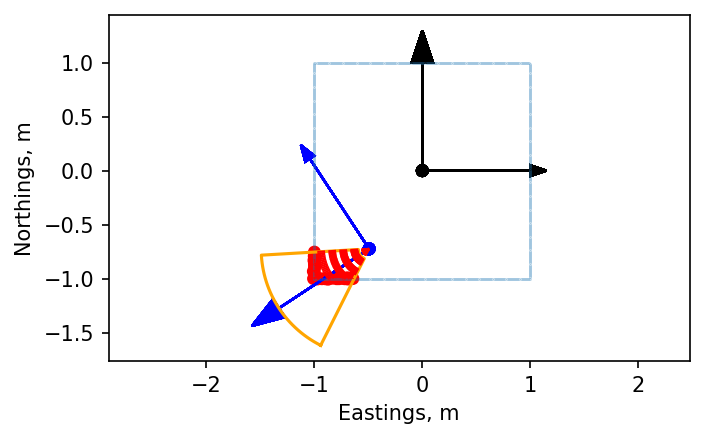

Max inflection value is  0.014299778478068861 : Threshold  0.007
Map observation made at, Northings =  [0.58422639] m, Eastings = [0.09027565] m


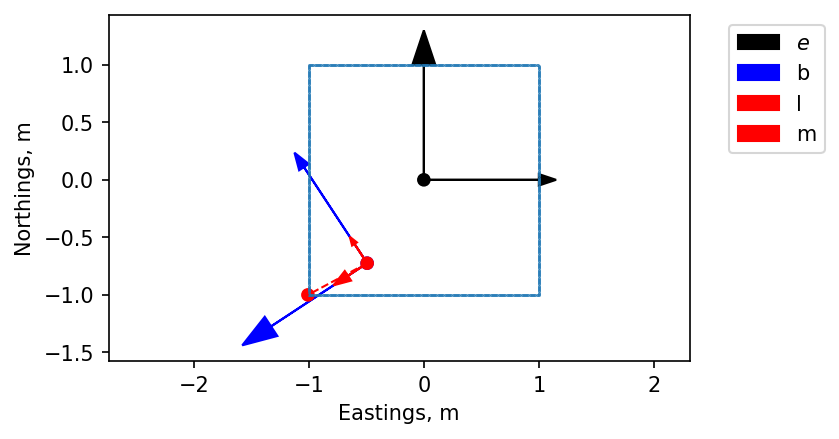

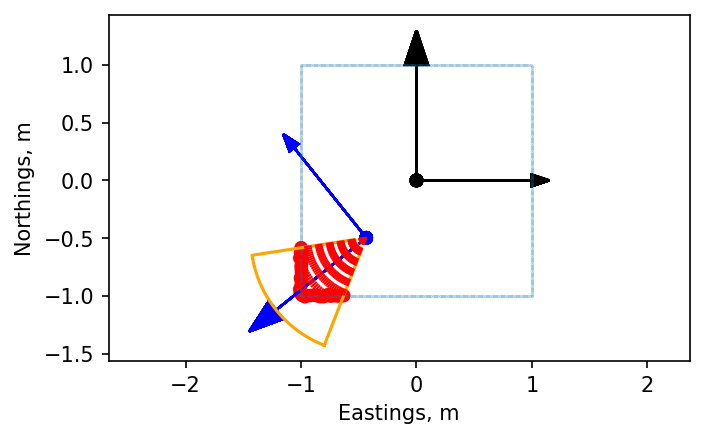

Max inflection value is  0.011070196245777243 : Threshold  0.007
Map observation made at, Northings =  [0.66928056] m, Eastings = [-0.16249617] m


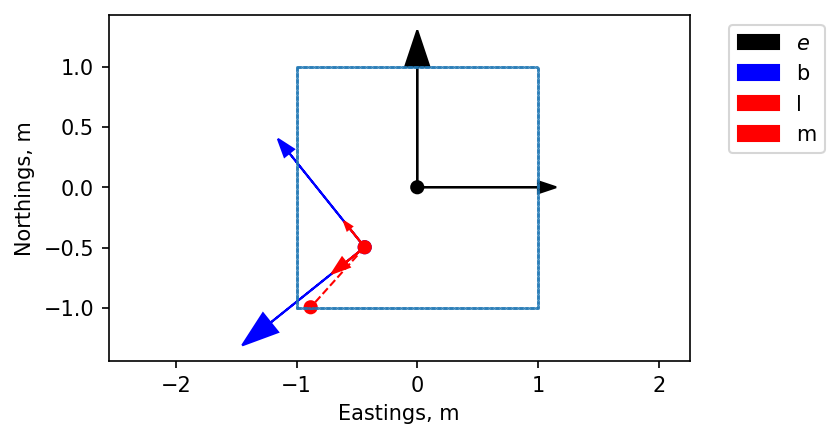

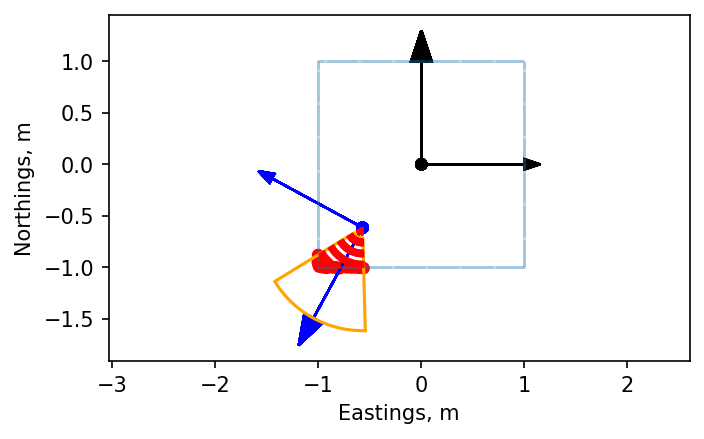

Max inflection value is  0.005814184309606823 : Threshold  0.007


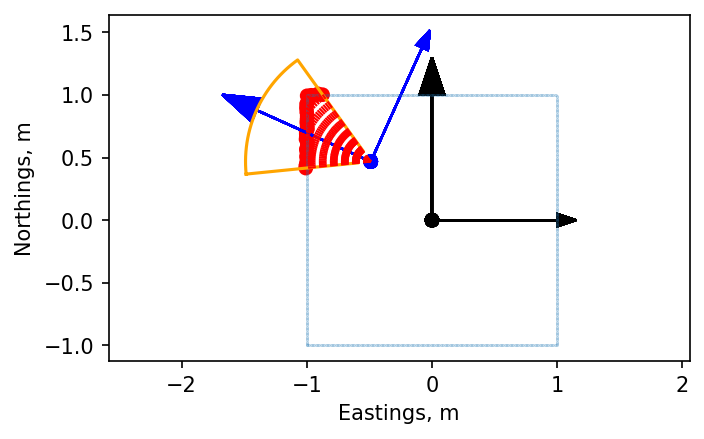

Max inflection value is  0.011102966141805656 : Threshold  0.007
Map observation made at, Northings =  [0.73102665] m, Eastings = [0.37915773] m


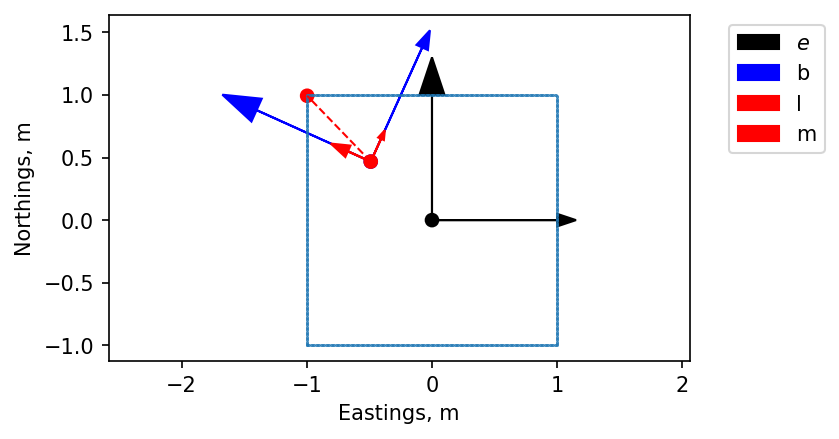

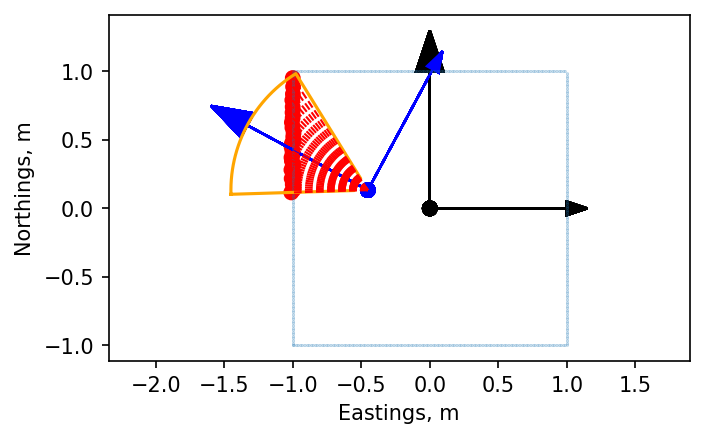

Max inflection value is  0.007373927829652953 : Threshold  0.007
Map observation made at, Northings =  [0.57741122] m, Eastings = [-0.23471669] m


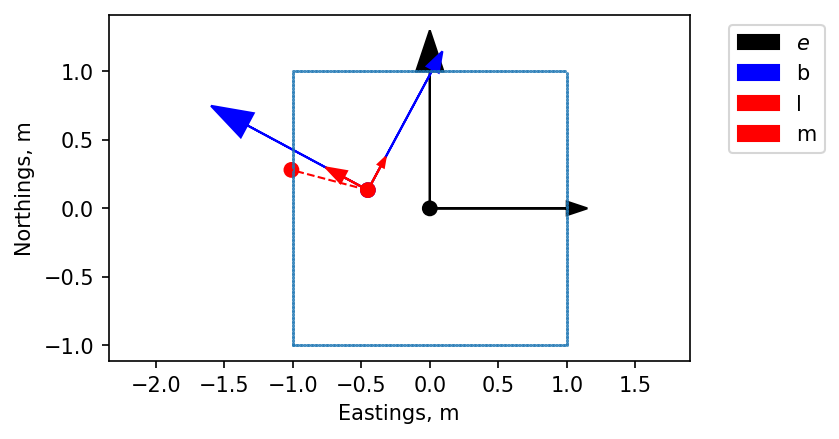

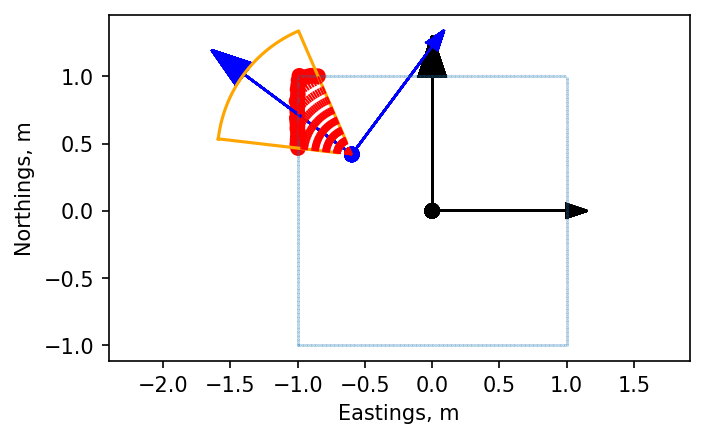

Max inflection value is  0.012192303319262028 : Threshold  0.007
Map observation made at, Northings =  [0.70339689] m, Eastings = [0.34304747] m


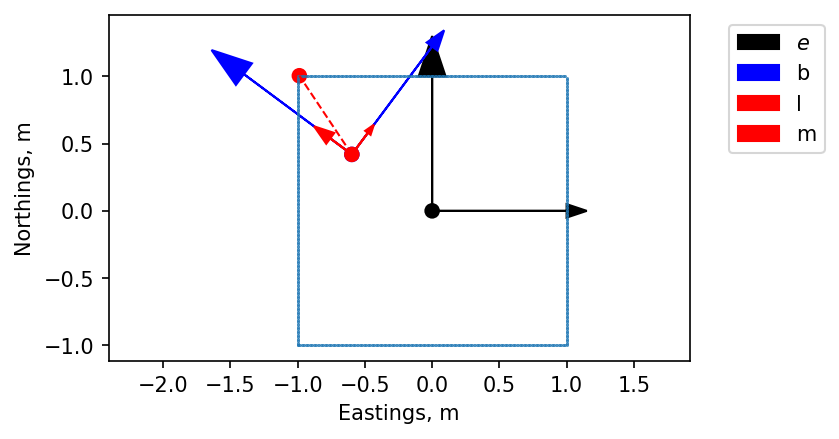

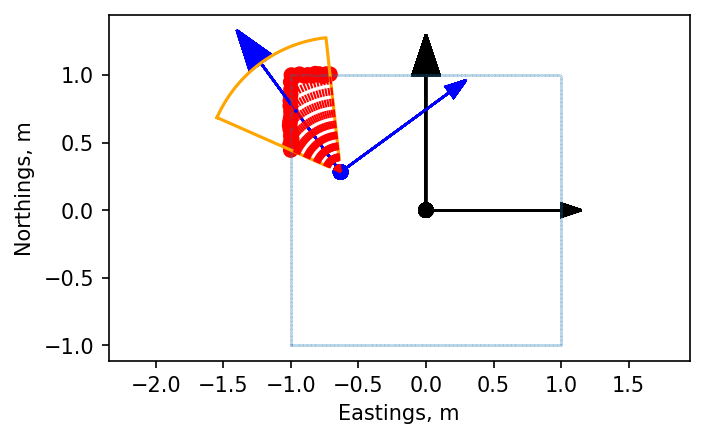

Max inflection value is  0.015139291697709494 : Threshold  0.007
Map observation made at, Northings =  [0.80509987] m, Eastings = [0.16249617] m


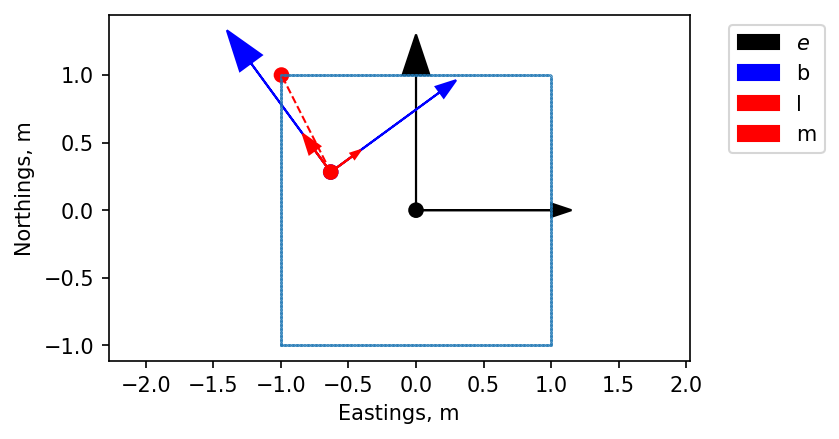

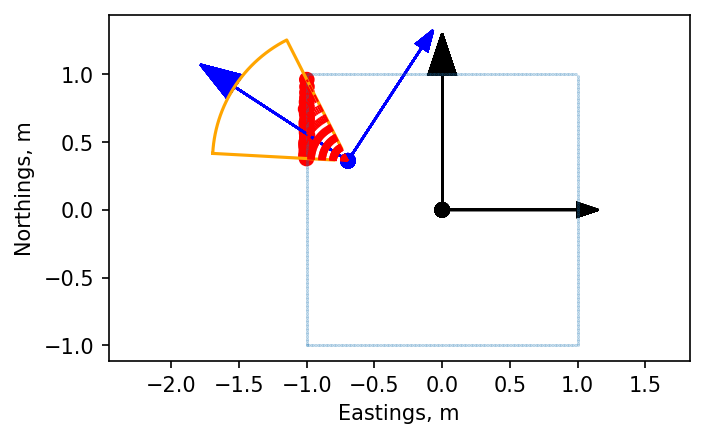

Max inflection value is  0.006179212165523966 : Threshold  0.007


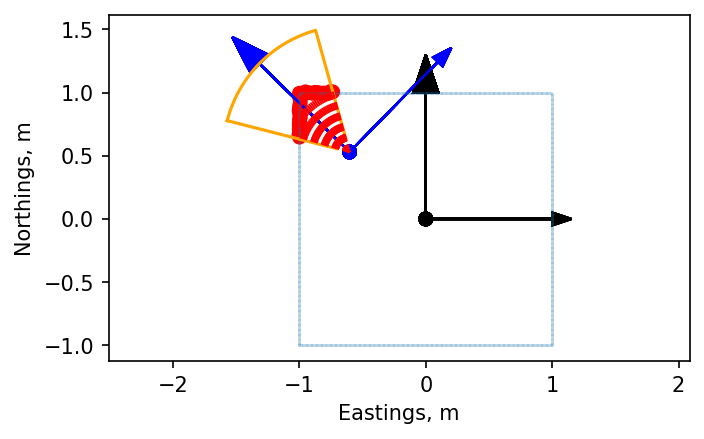

Max inflection value is  0.010298157191959062 : Threshold  0.007
Map observation made at, Northings =  [0.61237766] m, Eastings = [0.09027565] m


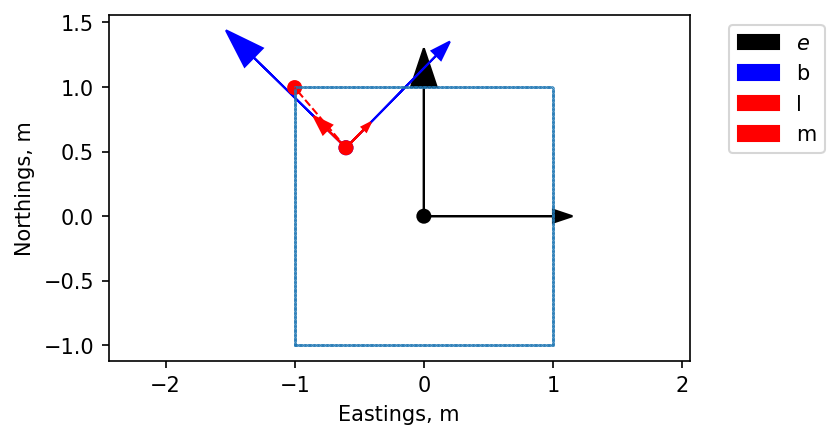

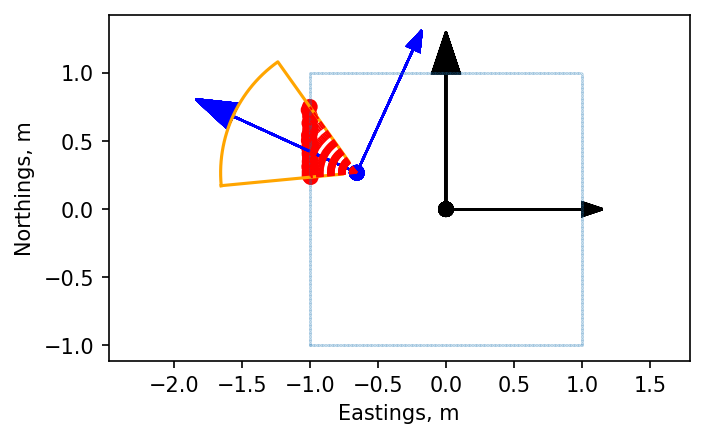

Max inflection value is  0.006500495011481283 : Threshold  0.007


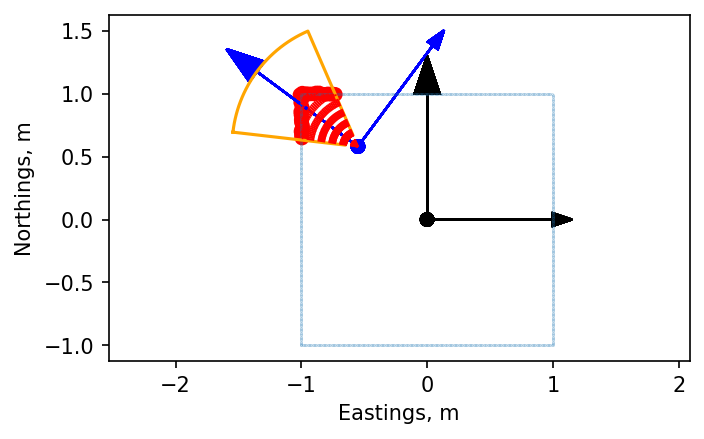

Max inflection value is  0.0109447963534419 : Threshold  0.007
Map observation made at, Northings =  [0.61280448] m, Eastings = [0.12638591] m


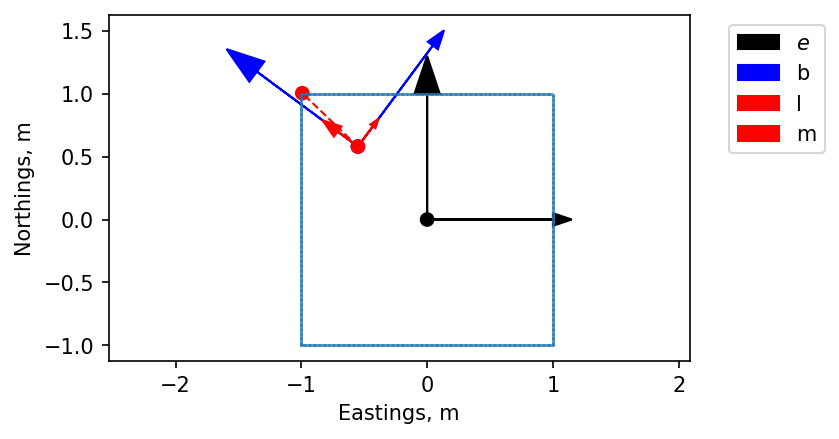

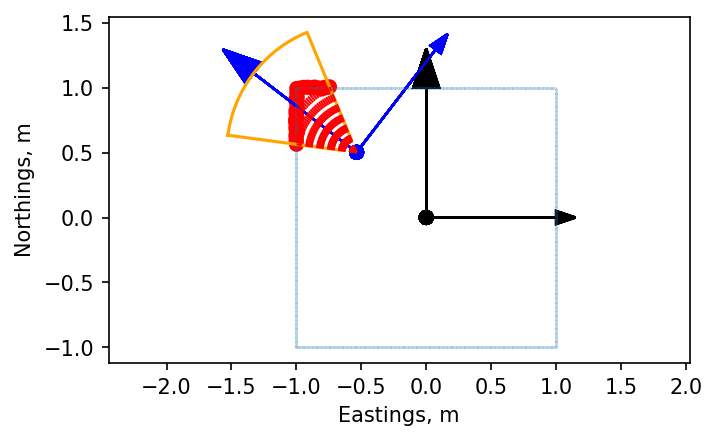

Max inflection value is  0.010840706998871776 : Threshold  0.007
Map observation made at, Northings =  [0.67460123] m, Eastings = [0.16249617] m


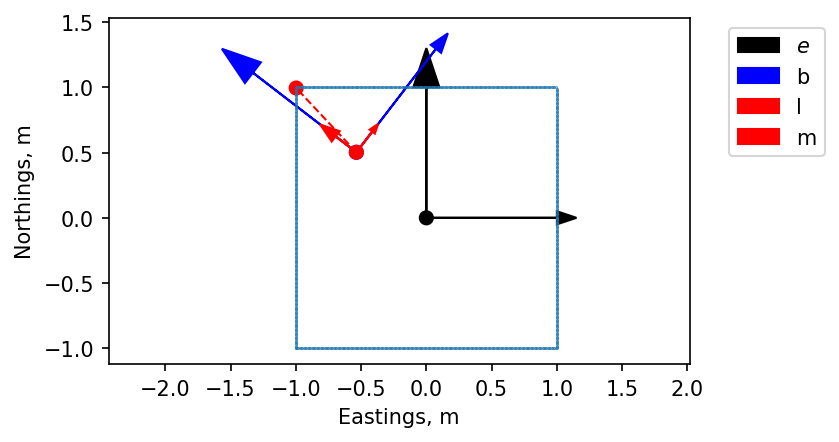

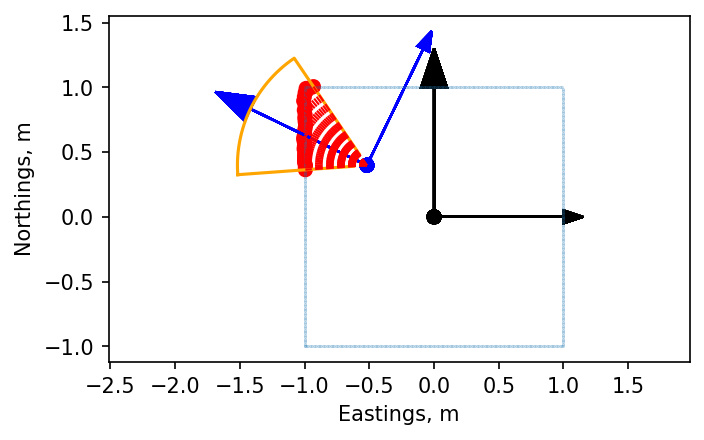

Max inflection value is  0.0079669496850591 : Threshold  0.007
Map observation made at, Northings =  [0.75746027] m, Eastings = [0.45137825] m


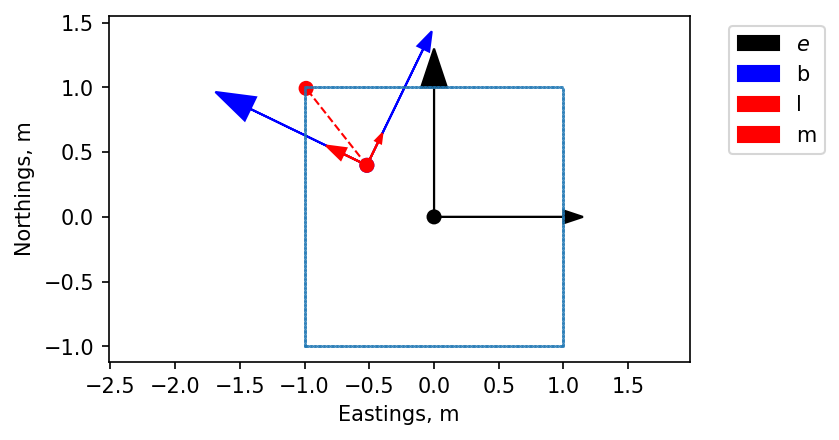

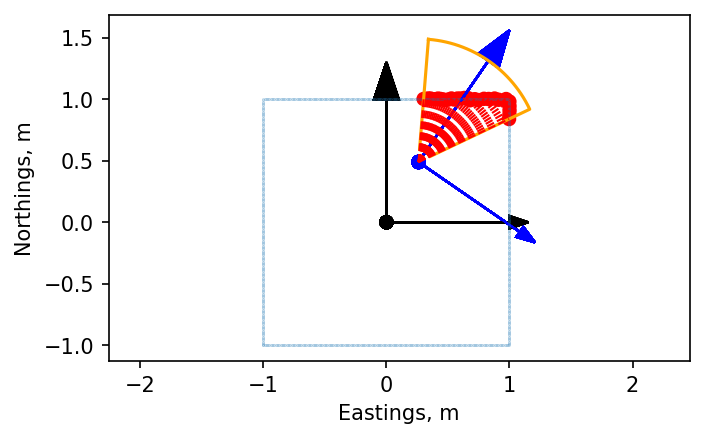

Max inflection value is  0.01267129847434869 : Threshold  0.007
Map observation made at, Northings =  [0.88696849] m, Eastings = [0.37915773] m


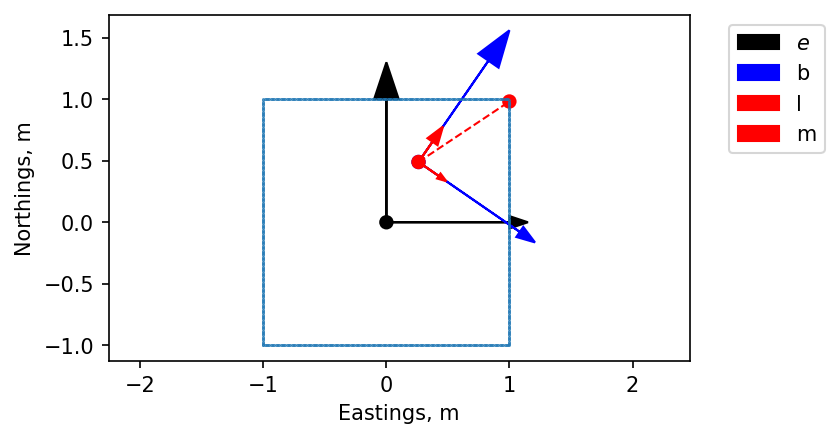

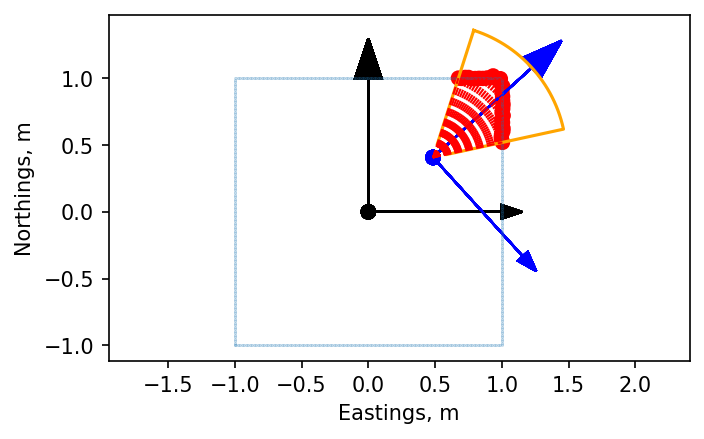

Max inflection value is  0.005266441444853755 : Threshold  0.007


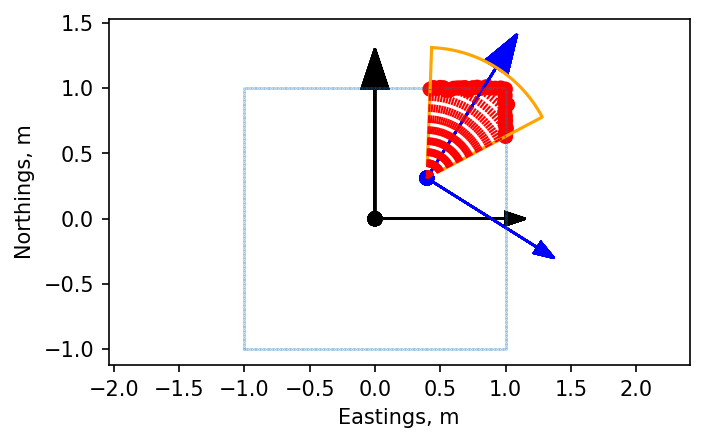

Max inflection value is  0.017039509385450805 : Threshold  0.007
Map observation made at, Northings =  [0.90894566] m, Eastings = [0.16249617] m


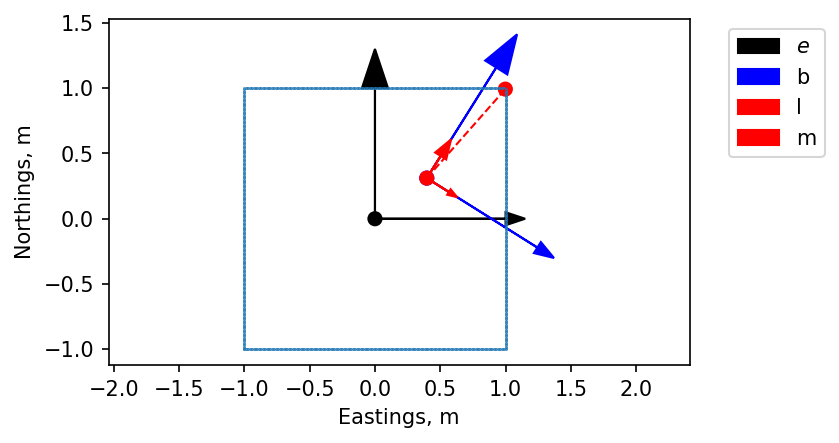

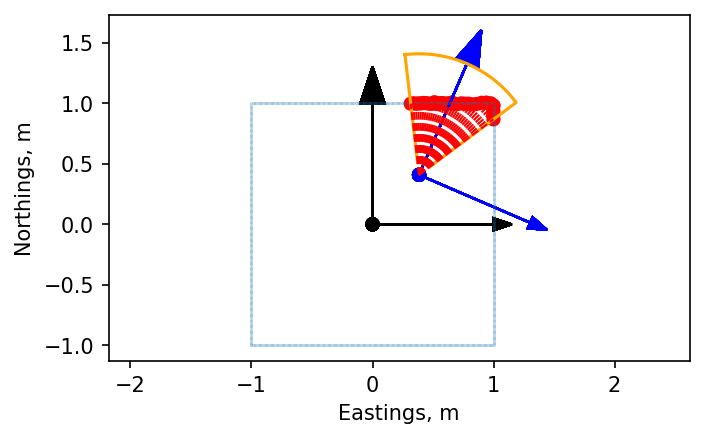

Max inflection value is  0.008371270322215664 : Threshold  0.007
Map observation made at, Northings =  [0.84081684] m, Eastings = [0.41526799] m


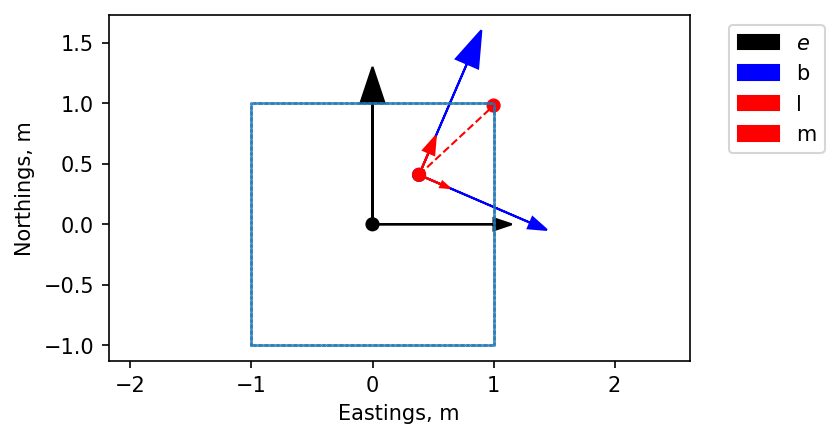

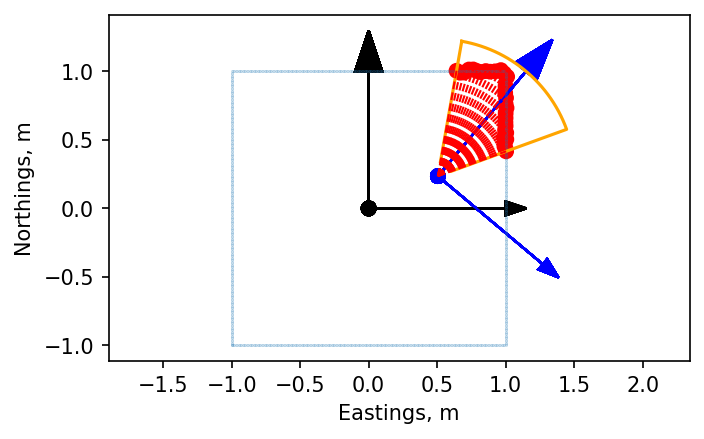

Max inflection value is  0.011372854557640637 : Threshold  0.007
Map observation made at, Northings =  [0.89281328] m, Eastings = [-0.12638591] m


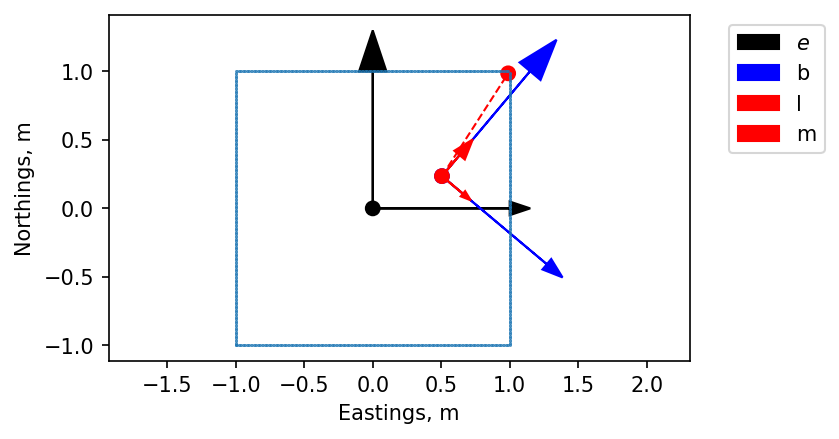

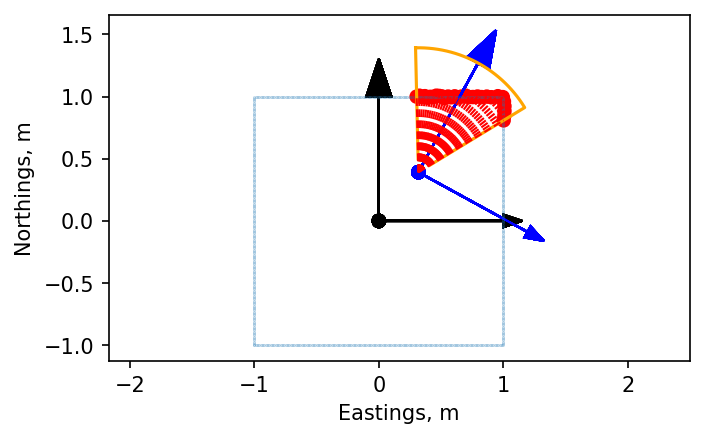

Max inflection value is  0.013367741160573945 : Threshold  0.007
Map observation made at, Northings =  [0.90804438] m, Eastings = [0.34304747] m


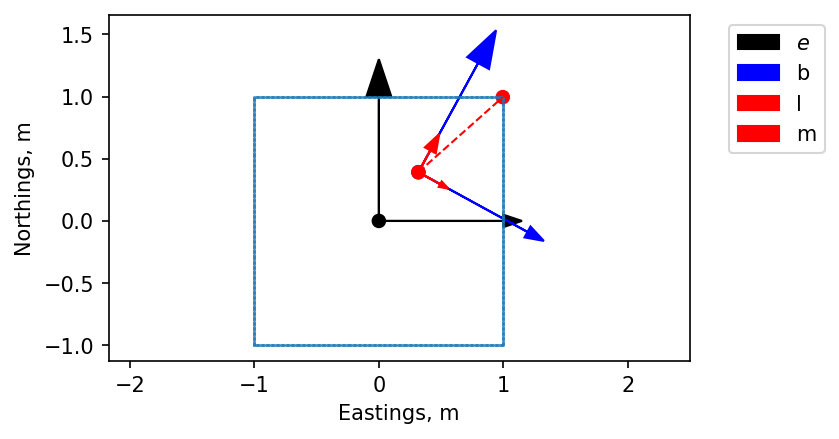

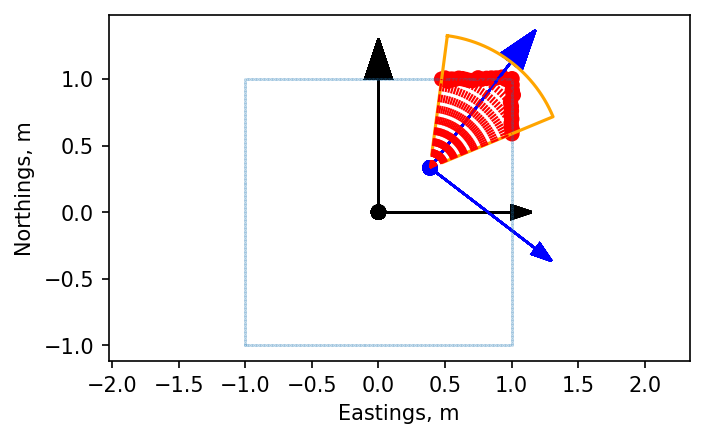

Max inflection value is  0.011333433916157584 : Threshold  0.007
Map observation made at, Northings =  [0.90882468] m, Eastings = [0.09027565] m


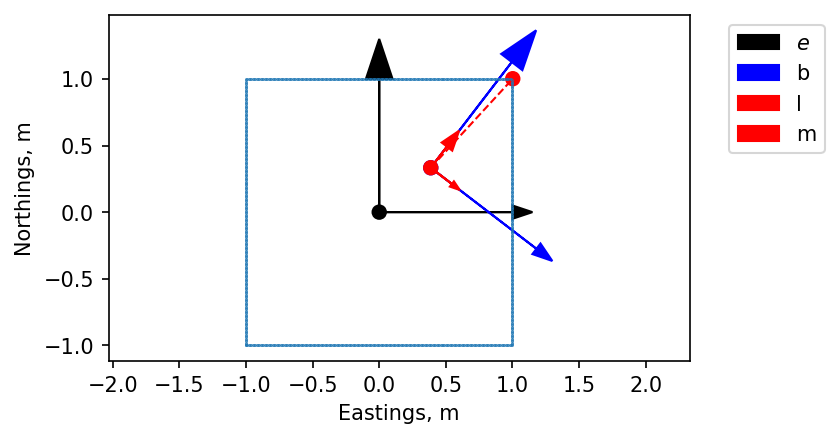

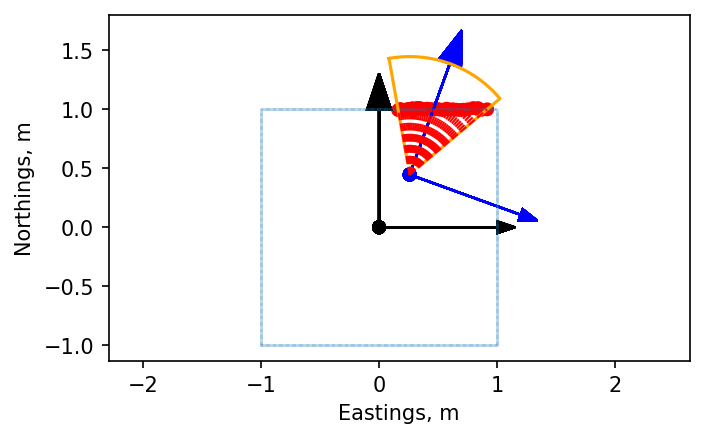

Max inflection value is  0.008473813808655459 : Threshold  0.007
Map observation made at, Northings =  [0.77987343] m, Eastings = [0.41526799] m


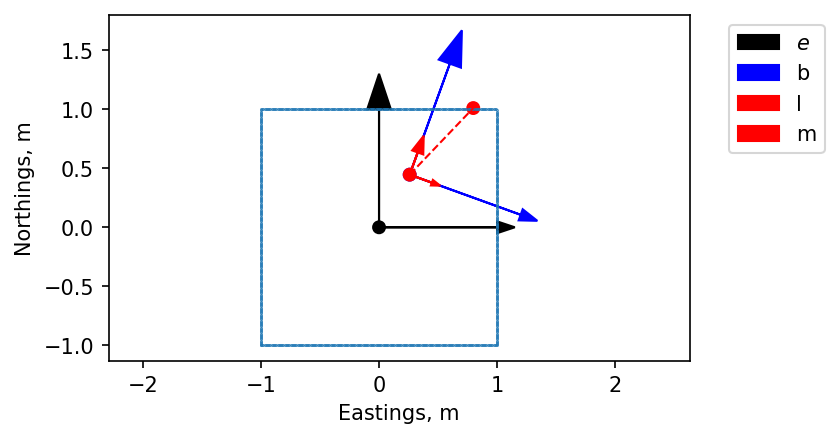

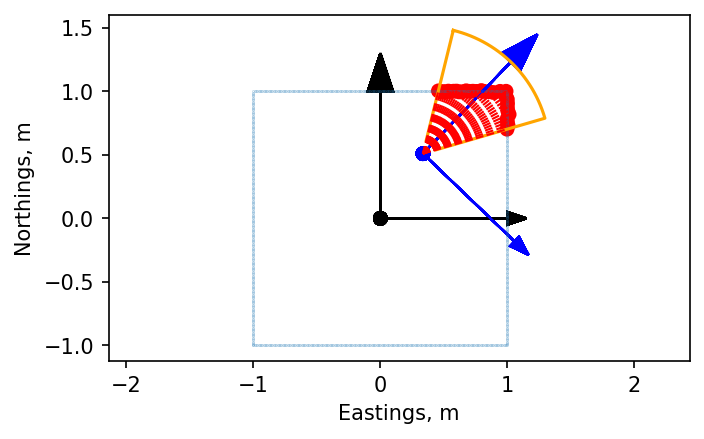

Max inflection value is  0.01639526081125693 : Threshold  0.007
Map observation made at, Northings =  [0.81846332] m, Eastings = [0.16249617] m


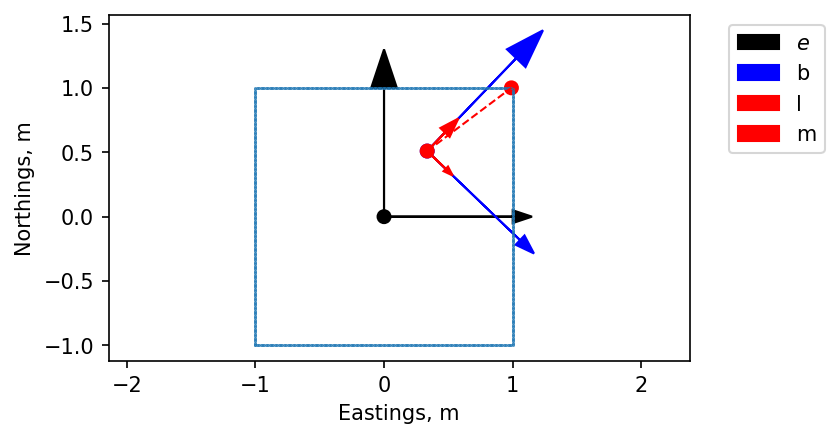

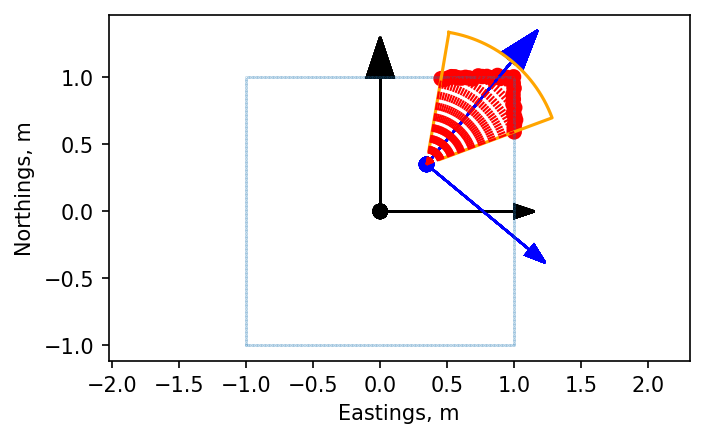

Max inflection value is  0.01824996718886404 : Threshold  0.007
Map observation made at, Northings =  [0.92169441] m, Eastings = [0.09027565] m


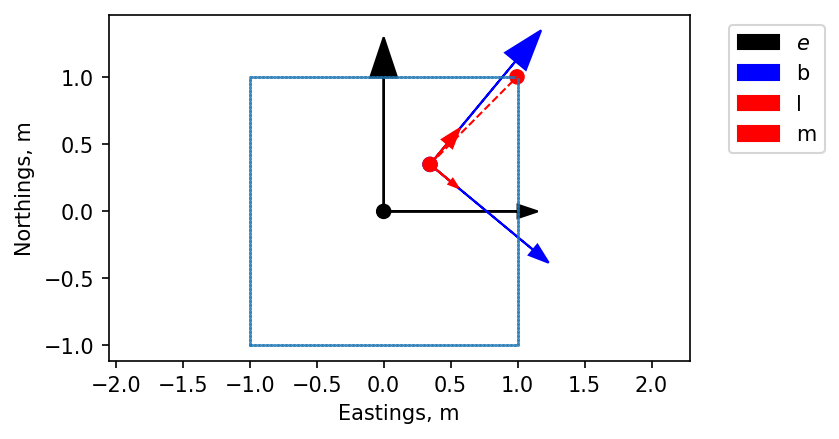

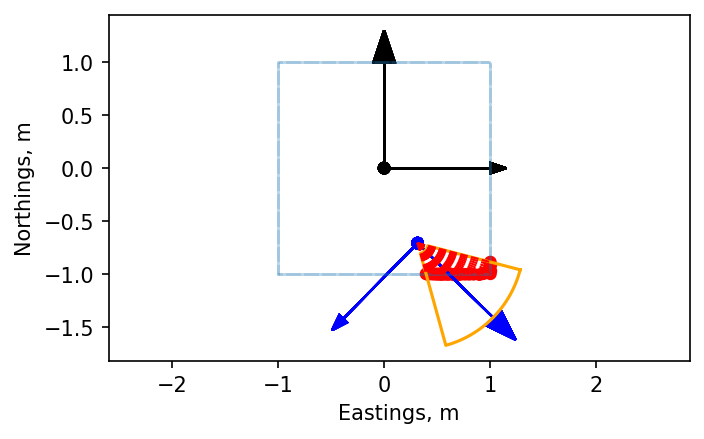

Max inflection value is  0.016454097340795268 : Threshold  0.007
Map observation made at, Northings =  [0.74546375] m, Eastings = [-0.37915773] m


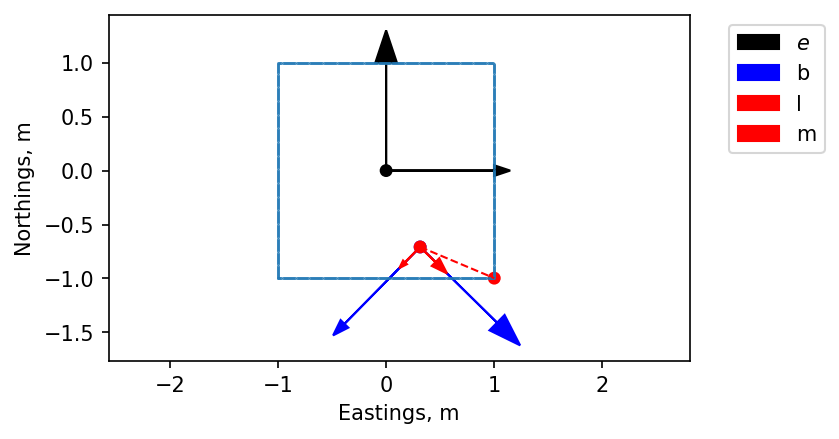

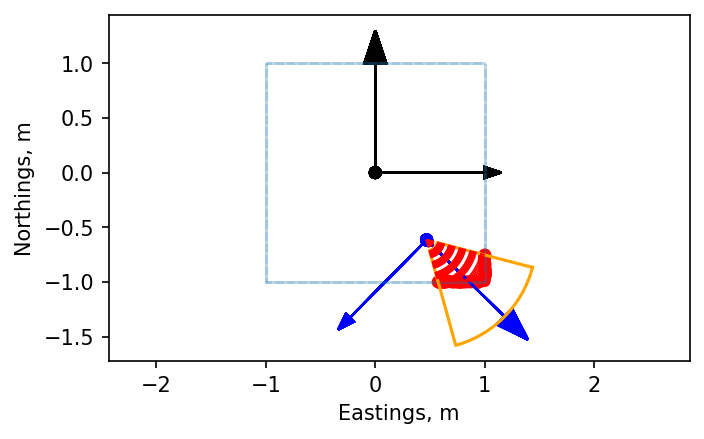

Max inflection value is  0.004861499596454356 : Threshold  0.007


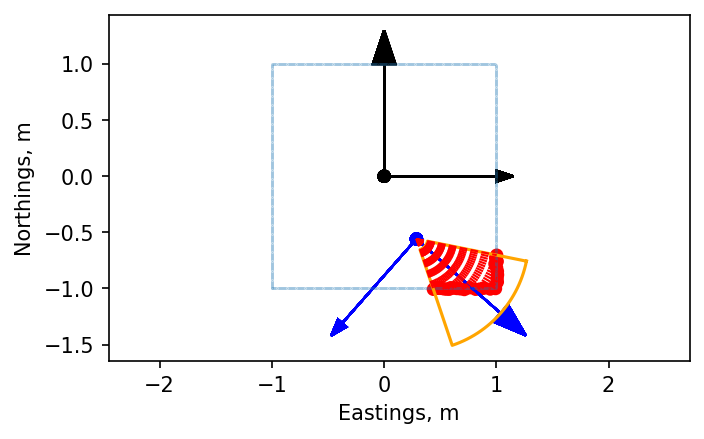

Max inflection value is  0.014759911441217938 : Threshold  0.007
Map observation made at, Northings =  [0.83205908] m, Eastings = [-0.16249617] m


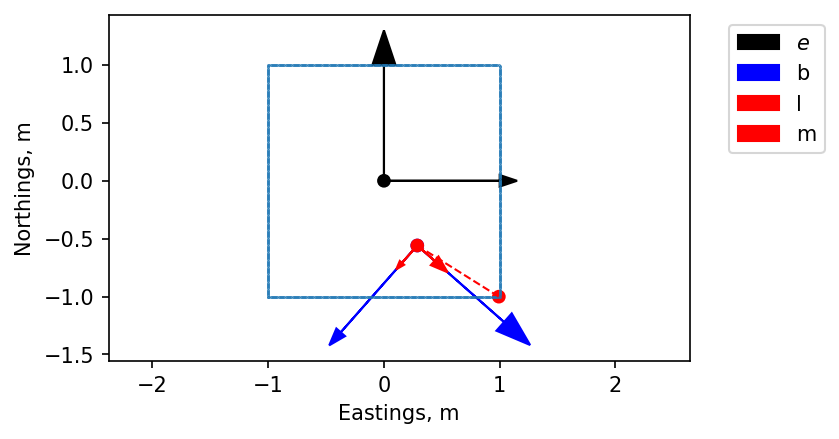

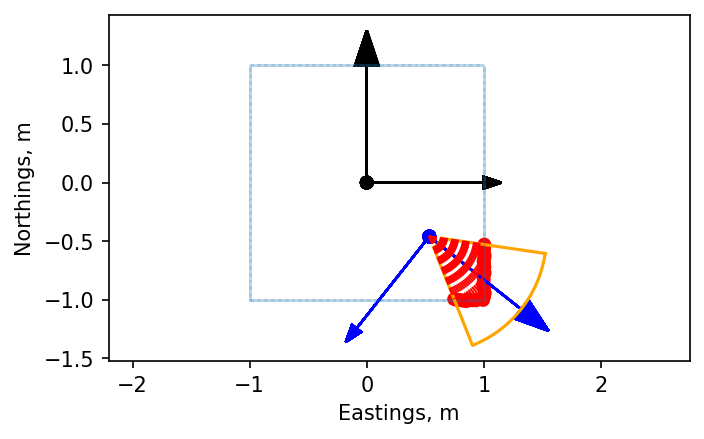

Max inflection value is  0.007609534256349797 : Threshold  0.007
Map observation made at, Northings =  [0.6953694] m, Eastings = [0.16249617] m


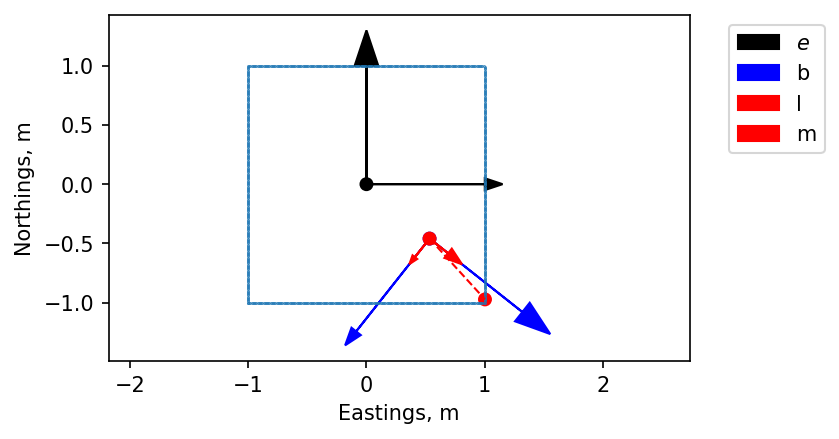

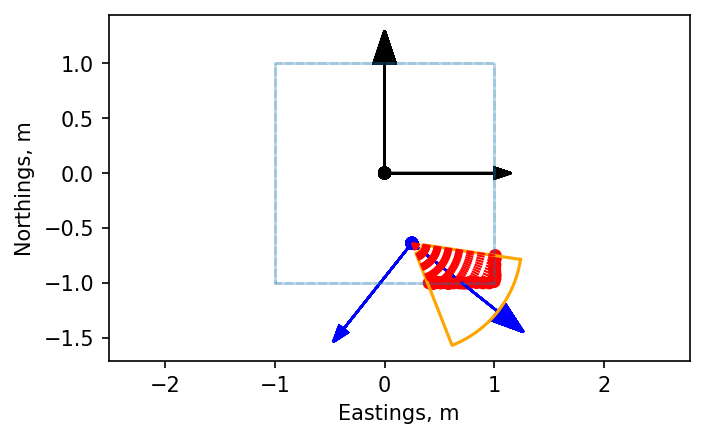

Max inflection value is  0.011053033823711887 : Threshold  0.007
Map observation made at, Northings =  [0.82550104] m, Eastings = [-0.23471669] m


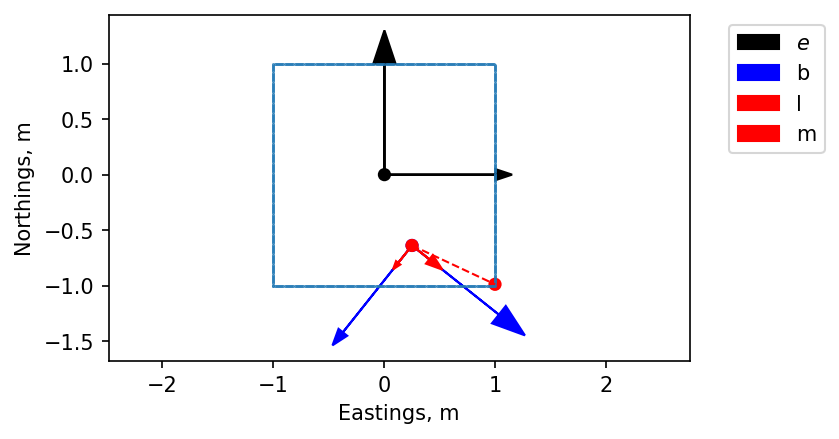

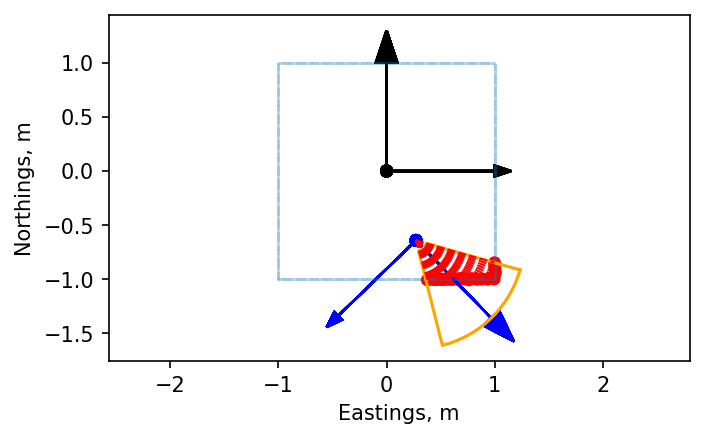

Max inflection value is  0.014105267554810633 : Threshold  0.007
Map observation made at, Northings =  [0.80667226] m, Eastings = [-0.34304747] m


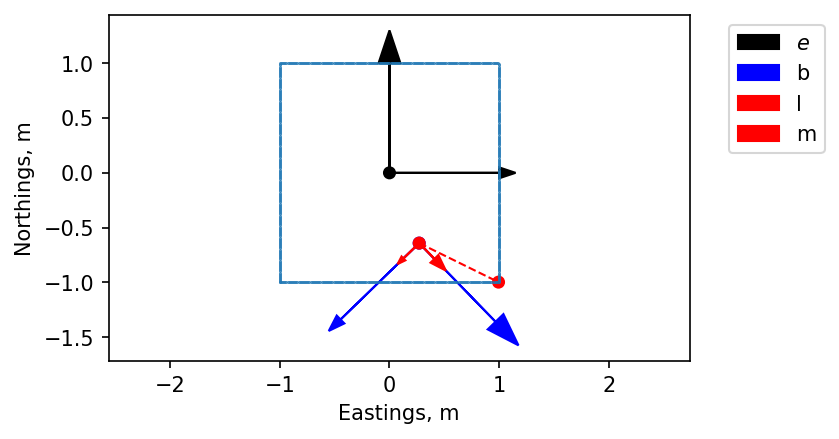

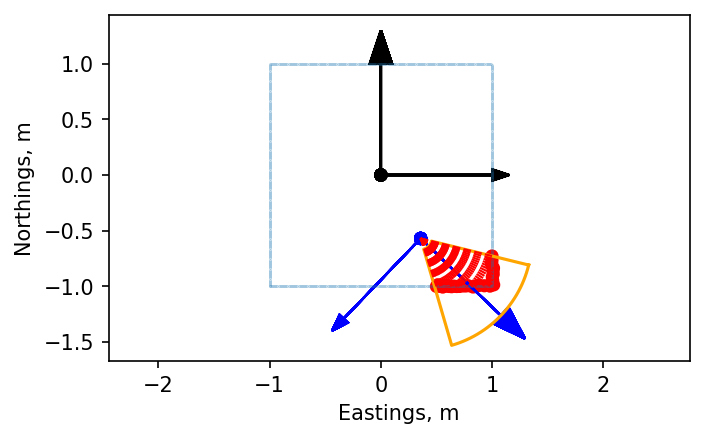

Max inflection value is  0.01626244308159243 : Threshold  0.007
Map observation made at, Northings =  [0.77764729] m, Eastings = [-0.19860643] m


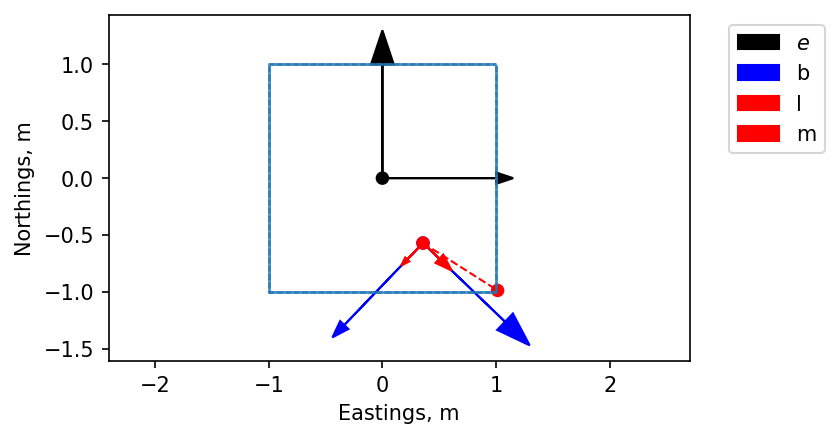

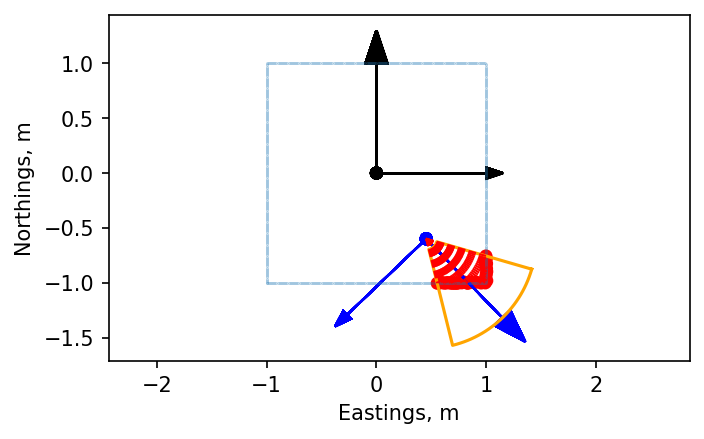

Max inflection value is  0.01421508424270651 : Threshold  0.007
Map observation made at, Northings =  [0.67161841] m, Eastings = [-0.16249617] m


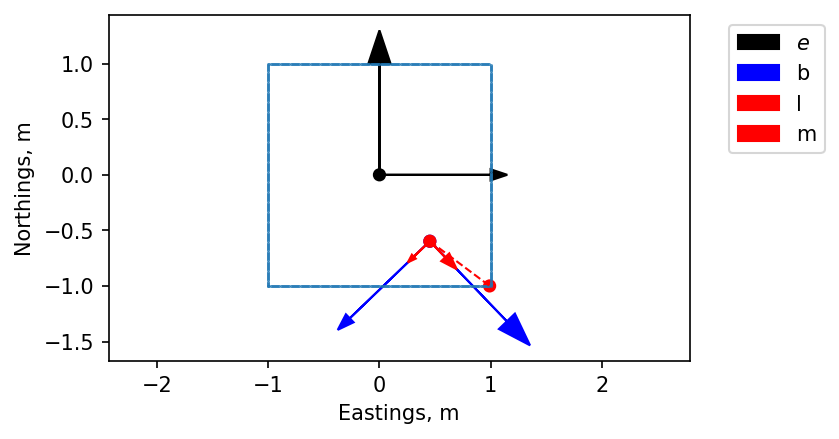

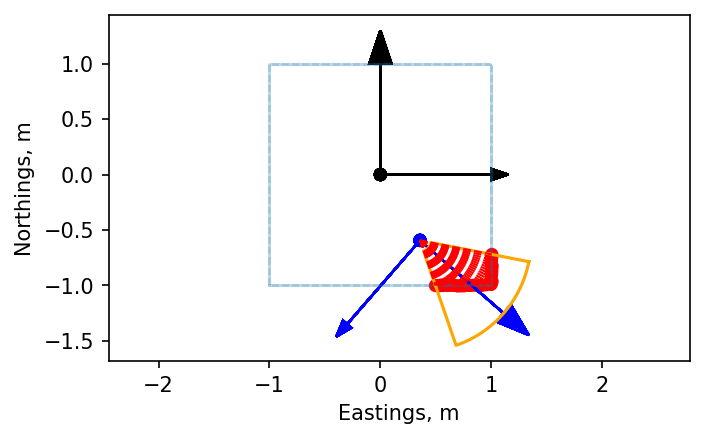

Max inflection value is  0.012842400858129592 : Threshold  0.007
Map observation made at, Northings =  [0.75437012] m, Eastings = [-0.16249617] m


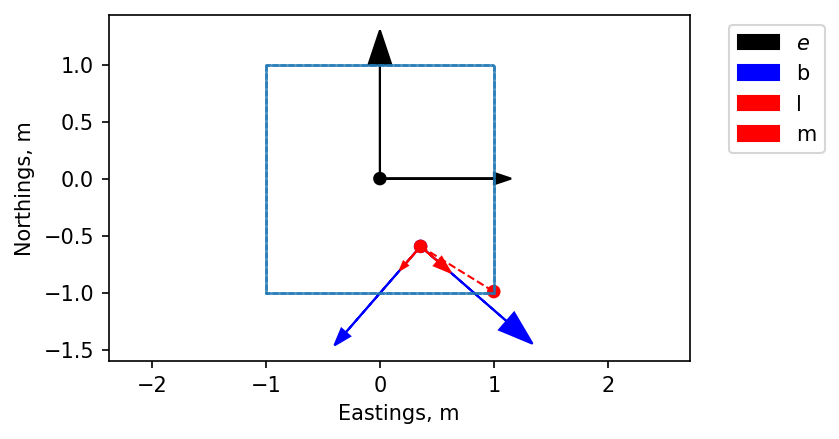

In [17]:
# decide some random position and angular offsets to make sure the training data is varied
pos_noise_std = 0.1
heading_noise_std = 10

# create a containor to store the GPC training data
corner_training = [corner_example]

for i in range(40):    
    # determine basic pose for each corner
    if i<=10: # southwest corner
        p[0] = -0.5
        p[1] = -0.5
        p[2] = np.deg2rad(225)
    elif i<=20: # northwest corner
        p[0] = 0.5
        p[1] = -0.5
        p[2] = np.deg2rad(315)
    elif i<=30: # northwest corner
        p[0] = 0.5
        p[1] = 0.5
        p[2] = np.deg2rad(45)
    else:
        p[0] = -0.5
        p[1] = 0.5
        p[2] = np.deg2rad(135)

    # add random offsets
    p[0] += np.random.normal(-pos_noise_std, pos_noise_std)
    p[1] += np.random.normal(-pos_noise_std, pos_noise_std)
    p[2] += np.deg2rad(np.random.normal(-heading_noise_std, heading_noise_std))
    
    # compute observations with noise
    observation, _ = lidar_scan(p, environment_map, lidar, sigma_observe)
    fig,ax = plt.subplots()
    show_scan(p, lidar, observation)
    ax.scatter(m_y, m_x,s=0.01)
    plt.show()

    # check if it is a corner with the inflection point
    new_observation = GPC_input_output(observation, None)
    
    threshold = 0.007 # can reduce to make less conservative
    z_lm[0], z_lm[1], loc = find_corner(new_observation, threshold)
    
    # if the bepoke model says returns a location, add to training data
    if loc is not None:
        # label corner and add to corner training set
        new_observation.label='corner'
        new_observation.ne_representative=z_lm
        print('Map observation made at, Northings = ',new_observation.ne_representative[0],'m, Eastings =',new_observation.ne_representative[1],'m')        
        corner_training.append(new_observation)
        
        # show pose and landmark 
        H_eb = HomogeneousTransformation(p[0:2],p[2])
        H_el.H = H_eb.H@lidar.H_bl.H        
        plot_2dframe(['observation','b','l','m'],[H_eb.H,H_el.H,z_lm],True)
        plt.scatter(m_x, m_y,s=0.1)
        plt.axis('equal')
        plt.show()

Add examples that are not corners. Can equally add other types of label as scilearn GPC will automatlically handle multi class datasets

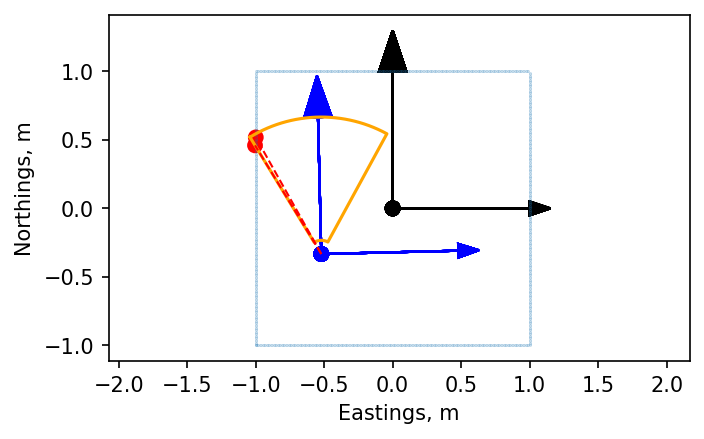

C:\Users\skyem\AppData\Local\Temp\ipykernel_30368\1458948444.py:144: RuntimeWarning: All-NaN slice encountered
  print('Max inflection value is ',np.nanmax(abs(np.gradient(np.gradient(curvature)))), ': Threshold ',threshold)
C:\Users\skyem\AppData\Local\Temp\ipykernel_30368\1458948444.py:145: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(abs(np.gradient(np.gradient(curvature)))) > threshold:


Max inflection value is  nan : Threshold  0.01


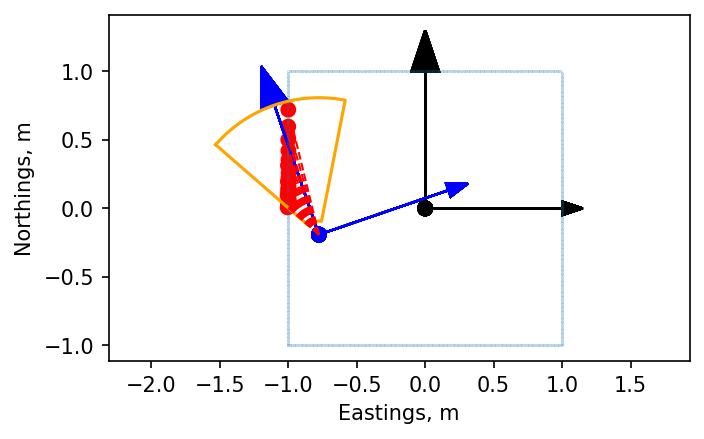

Max inflection value is  0.004459935352251546 : Threshold  0.01


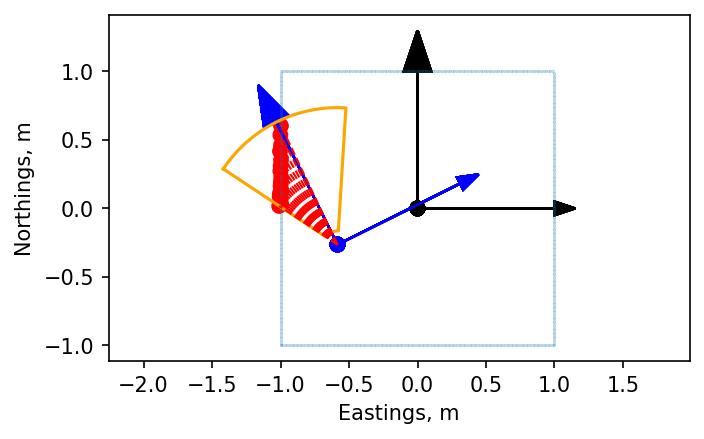

Max inflection value is  0.008782985831554187 : Threshold  0.01


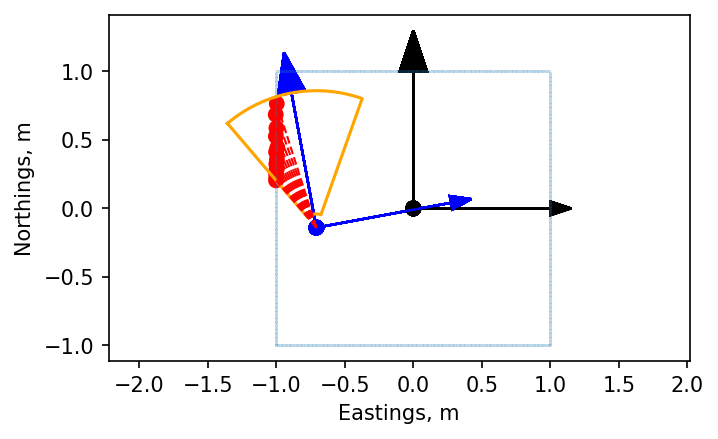

Max inflection value is  0.004055165032698434 : Threshold  0.01


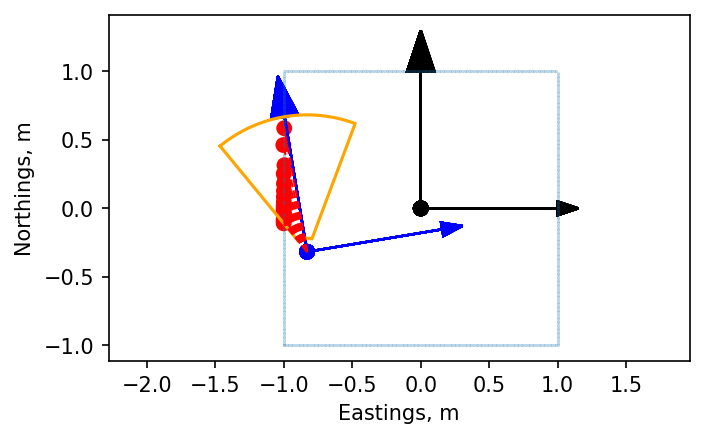

Max inflection value is  0.005681845366879223 : Threshold  0.01


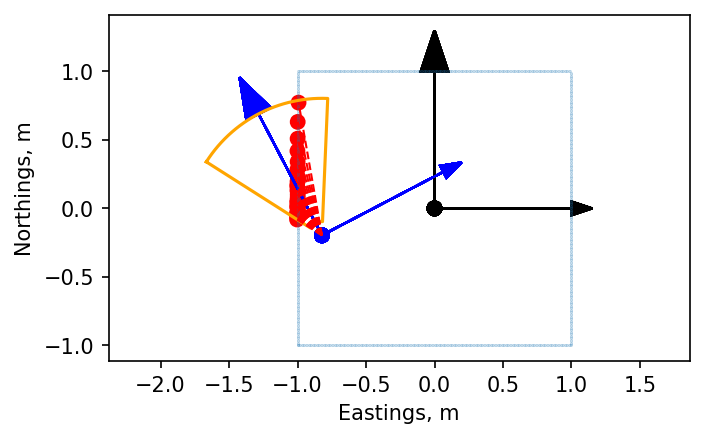

Max inflection value is  0.004736332894146791 : Threshold  0.01


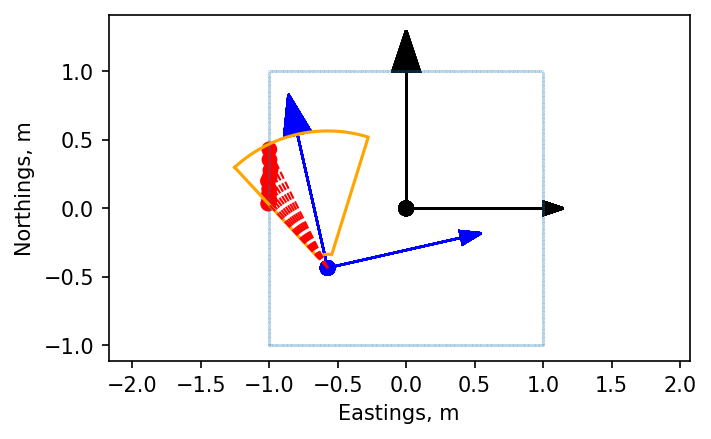

Max inflection value is  0.010639838805738391 : Threshold  0.01


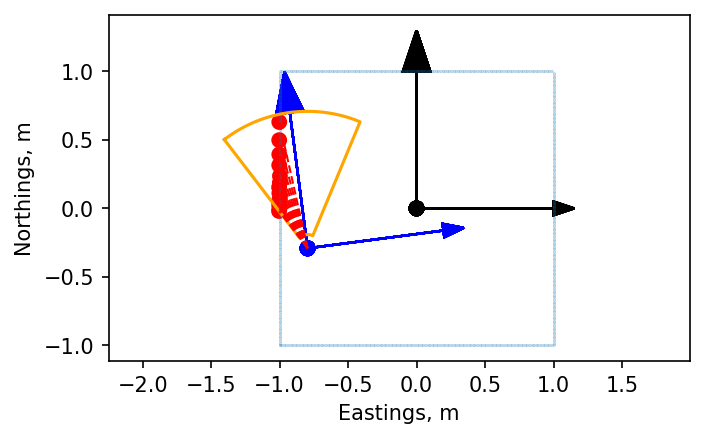

Max inflection value is  0.007853387269644858 : Threshold  0.01


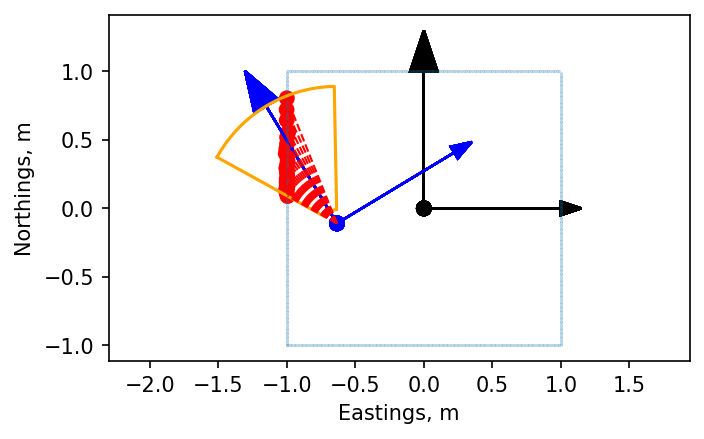

Max inflection value is  0.007149295512211606 : Threshold  0.01


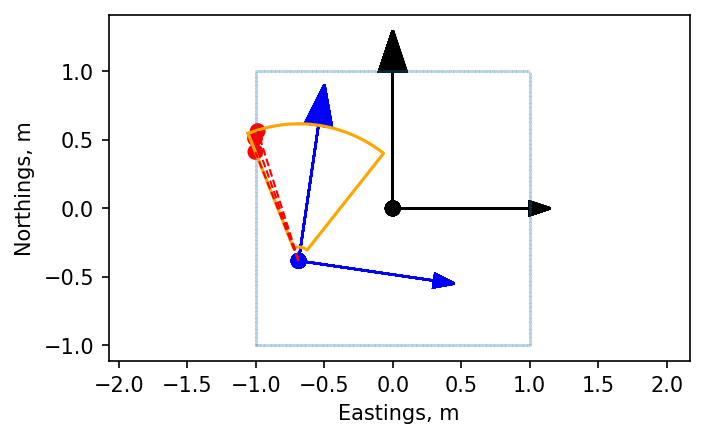

Max inflection value is  nan : Threshold  0.01


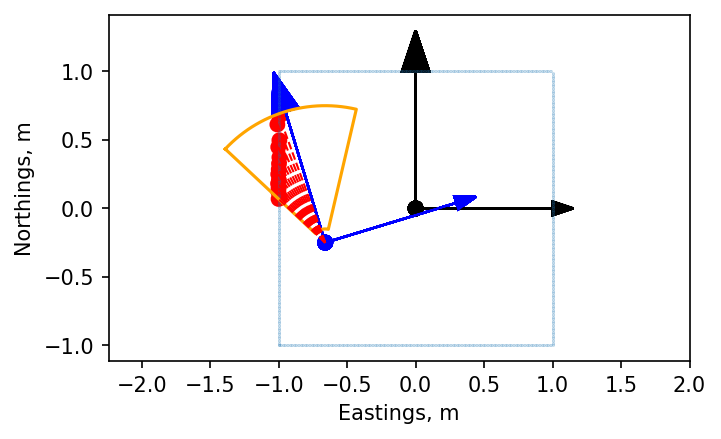

Max inflection value is  0.005008522006253544 : Threshold  0.01


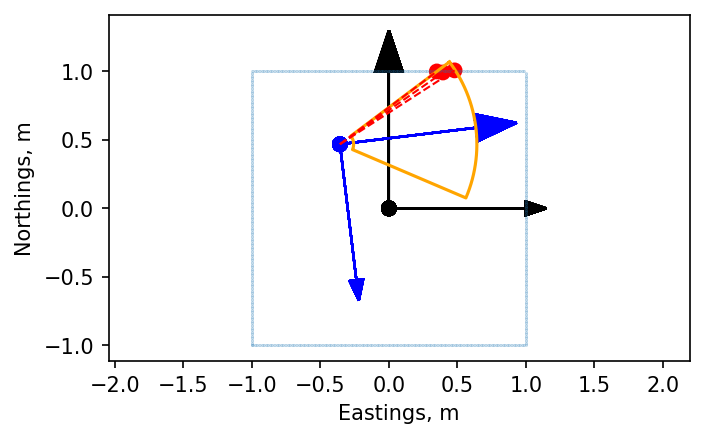

Max inflection value is  nan : Threshold  0.01


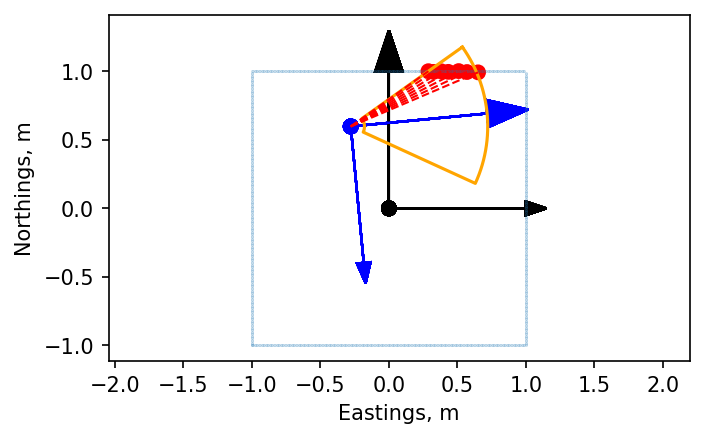

Max inflection value is  0.0007453205052545403 : Threshold  0.01


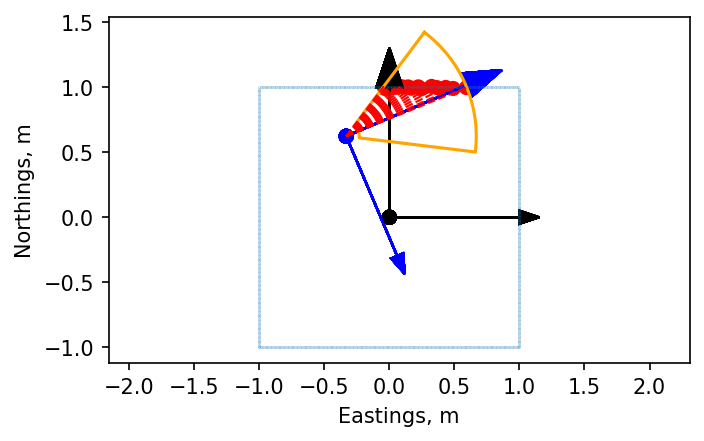

Max inflection value is  0.005090337044476909 : Threshold  0.01


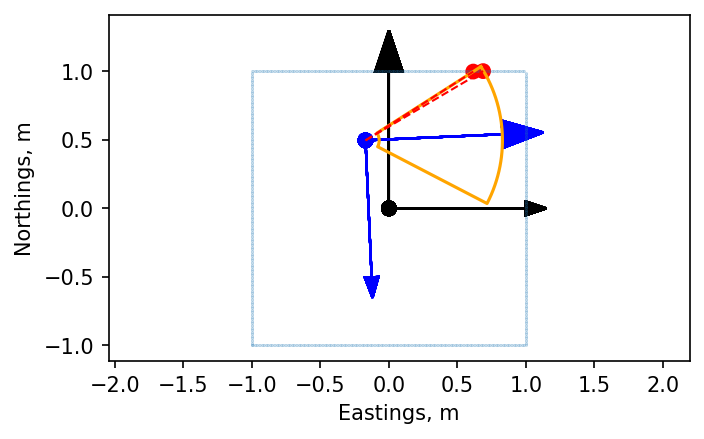

Max inflection value is  nan : Threshold  0.01


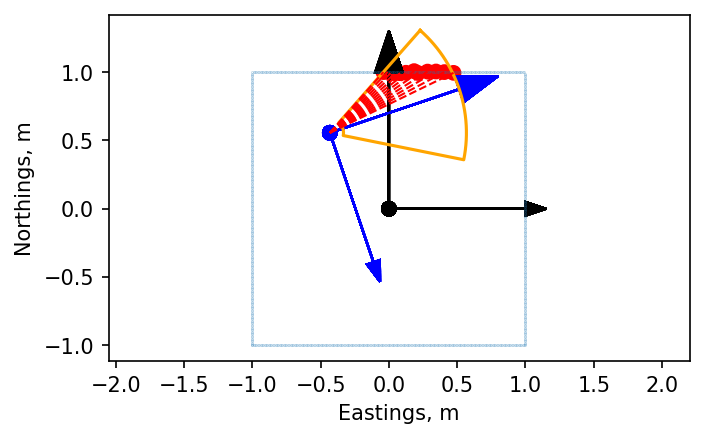

Max inflection value is  0.0076197535028579705 : Threshold  0.01


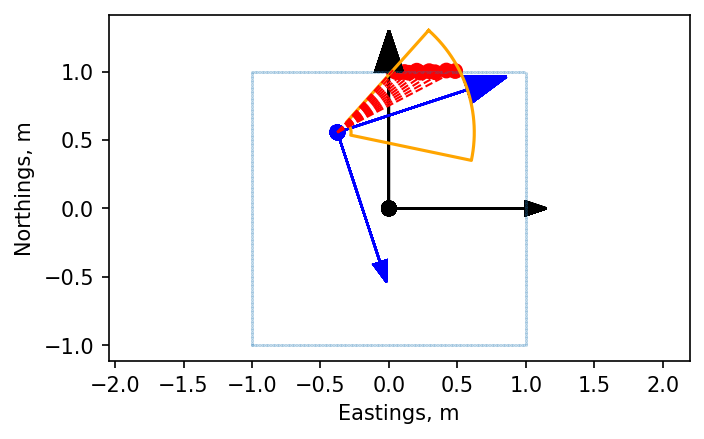

Max inflection value is  0.004696839513176898 : Threshold  0.01


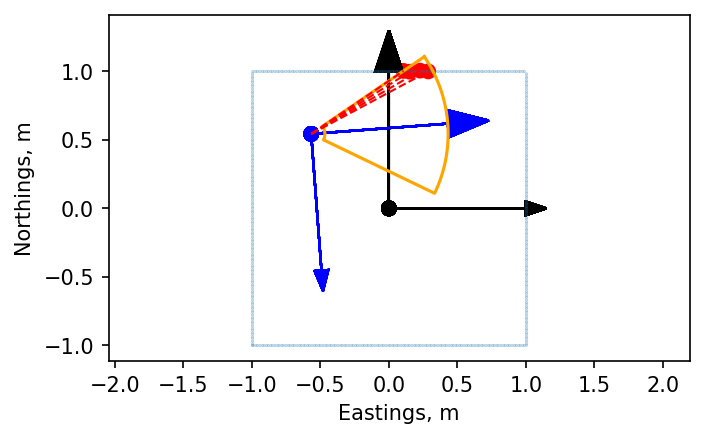

Max inflection value is  nan : Threshold  0.01


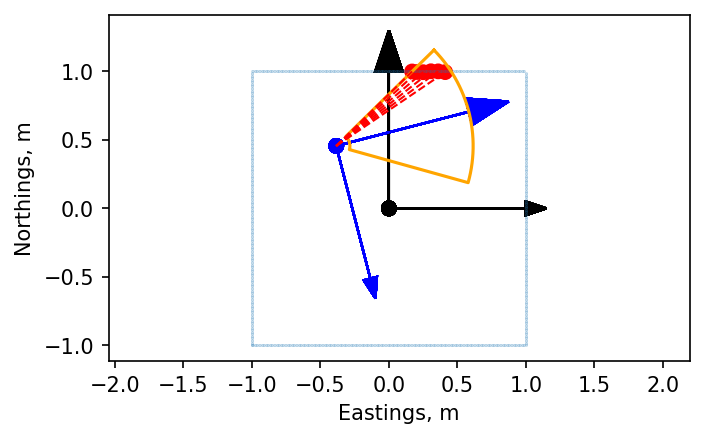

Max inflection value is  0.004034745318457149 : Threshold  0.01


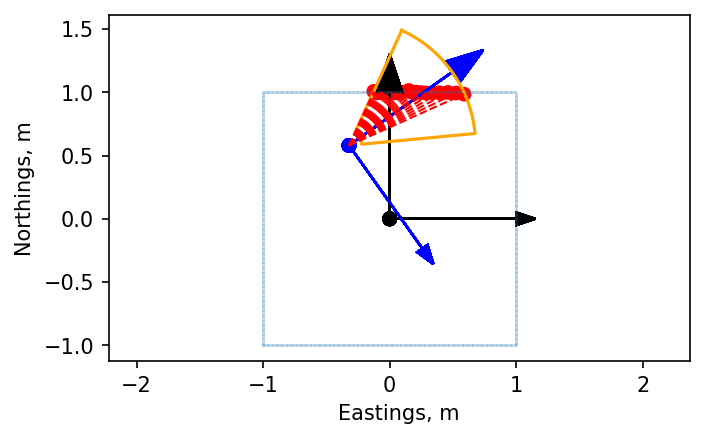

Max inflection value is  0.007717784720963551 : Threshold  0.01


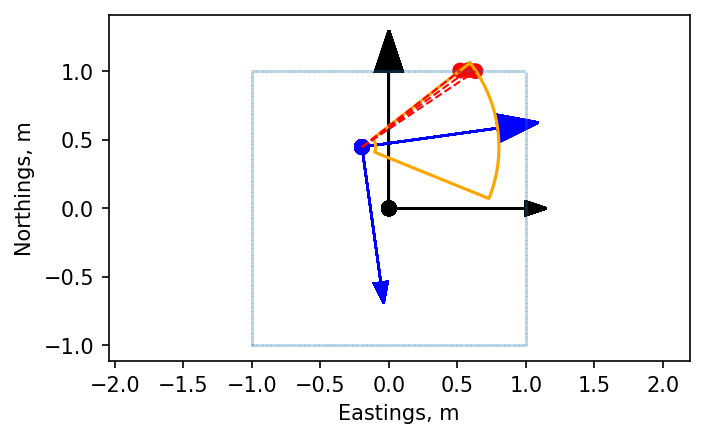

Max inflection value is  nan : Threshold  0.01


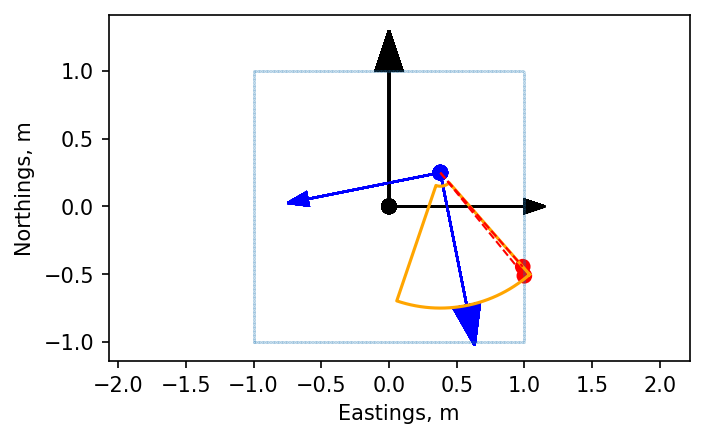

Max inflection value is  nan : Threshold  0.01


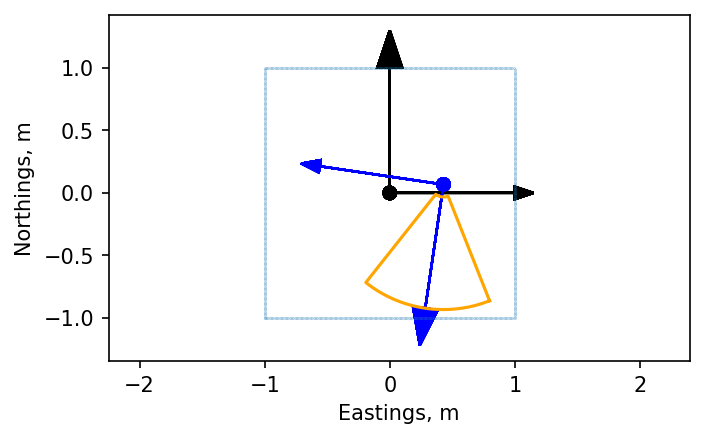

C:\Users\skyem\AppData\Local\Temp\ipykernel_30368\1458948444.py:175: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(data[:,0])


Max inflection value is  nan : Threshold  0.01


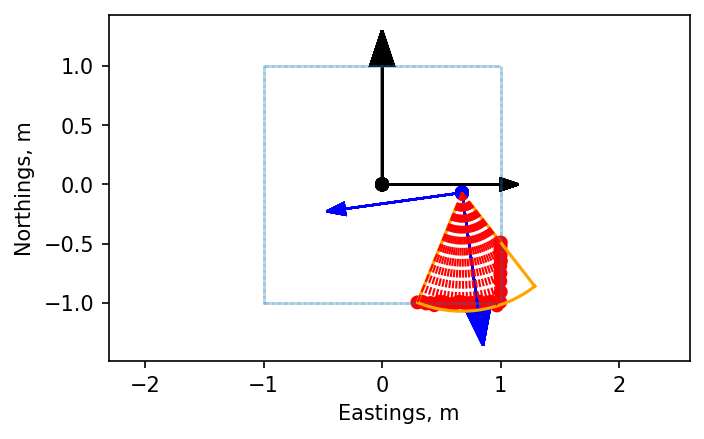

Max inflection value is  0.02819899734941552 : Threshold  0.01


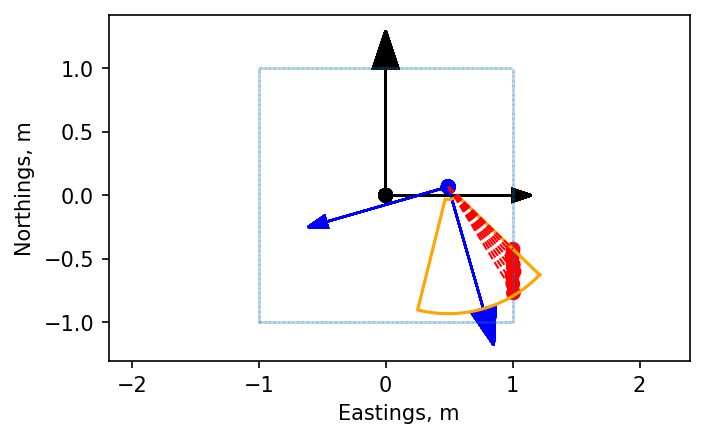

Max inflection value is  0.008689799337658621 : Threshold  0.01


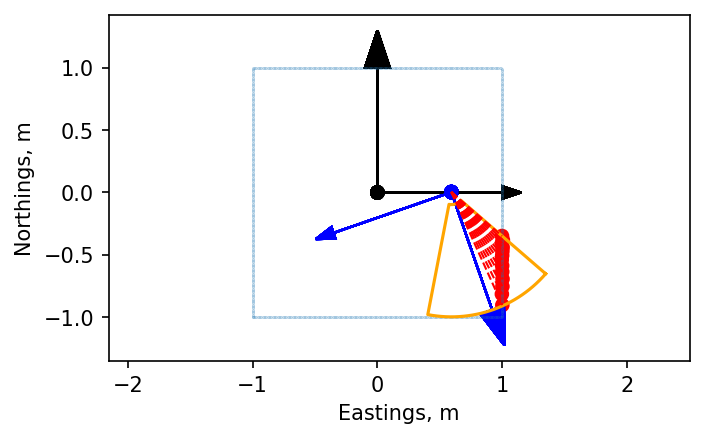

Max inflection value is  0.004147445789289821 : Threshold  0.01


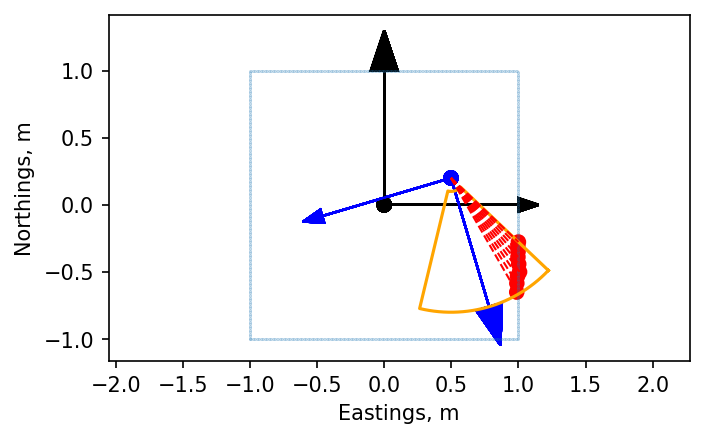

Max inflection value is  0.005310206175044373 : Threshold  0.01


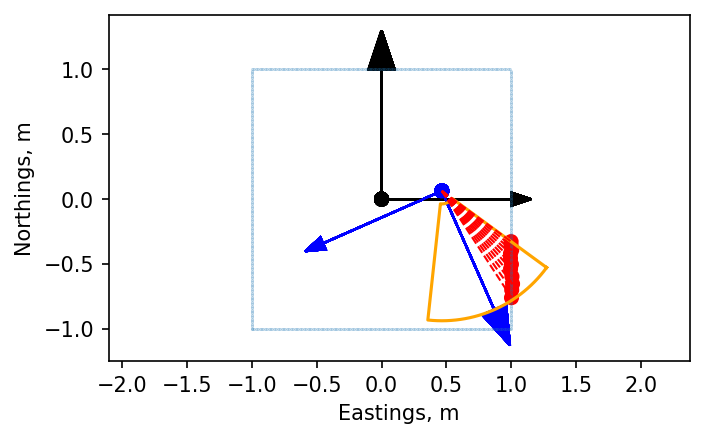

Max inflection value is  0.0045461066440349515 : Threshold  0.01


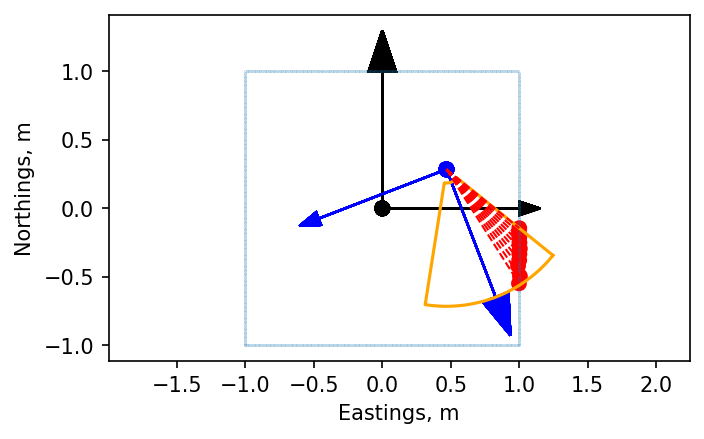

Max inflection value is  0.003419912574329824 : Threshold  0.01


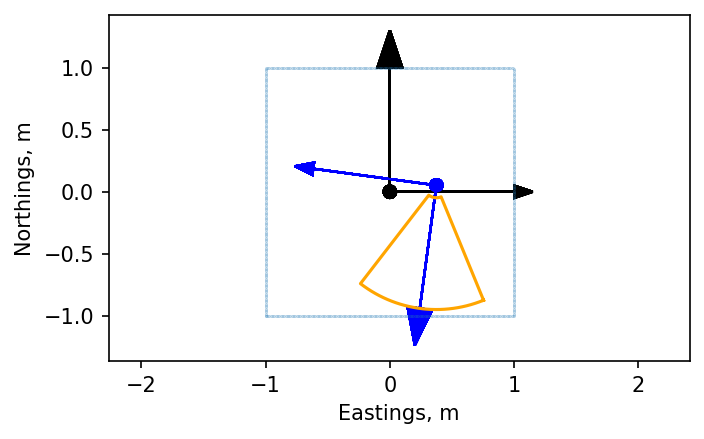

Max inflection value is  nan : Threshold  0.01


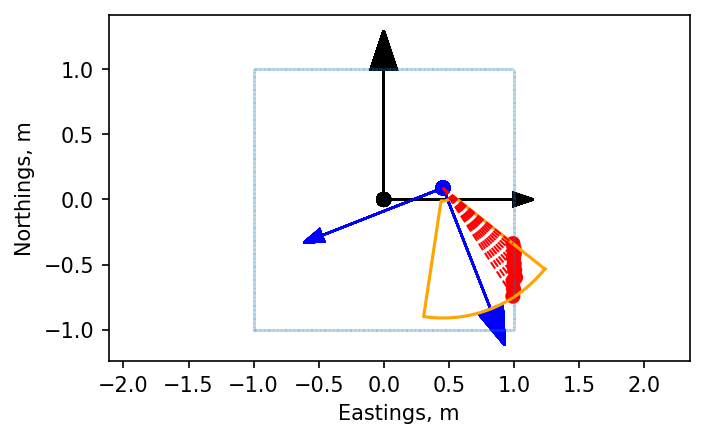

Max inflection value is  0.0065520416459093345 : Threshold  0.01


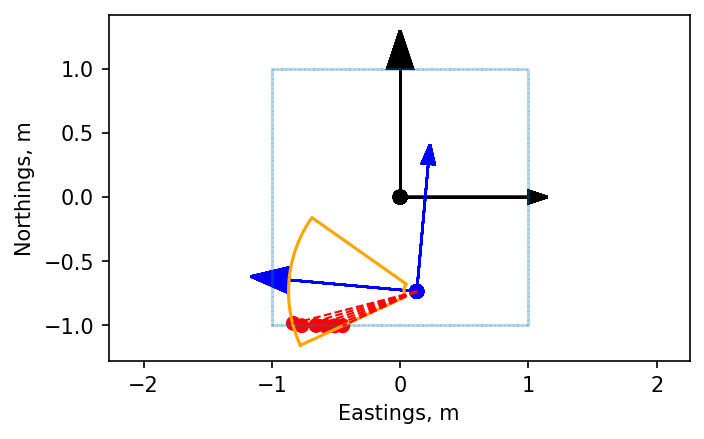

Max inflection value is  0.003318508007111712 : Threshold  0.01


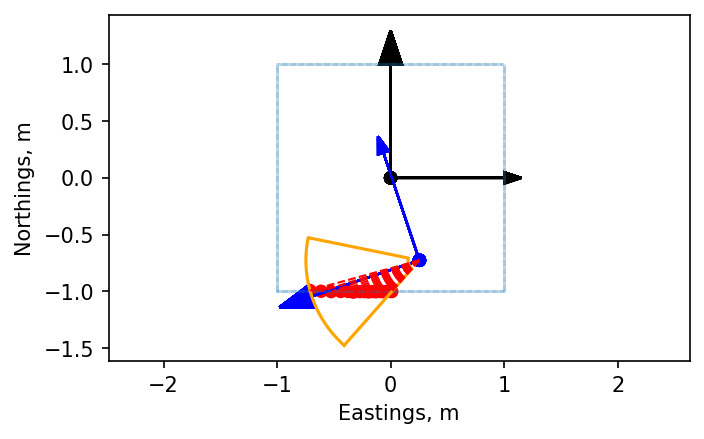

Max inflection value is  0.00482156335966831 : Threshold  0.01


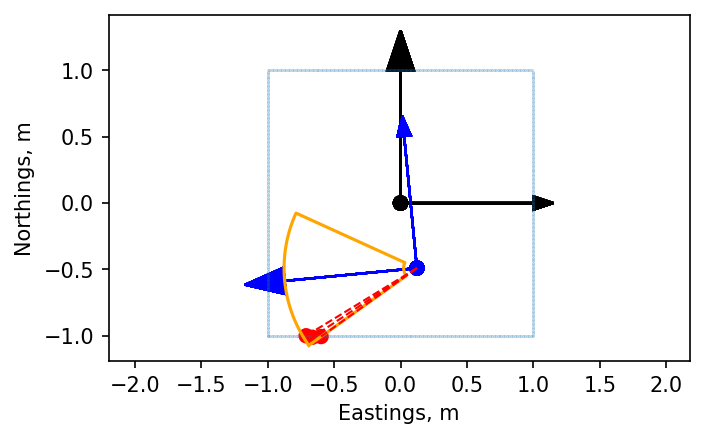

Max inflection value is  nan : Threshold  0.01


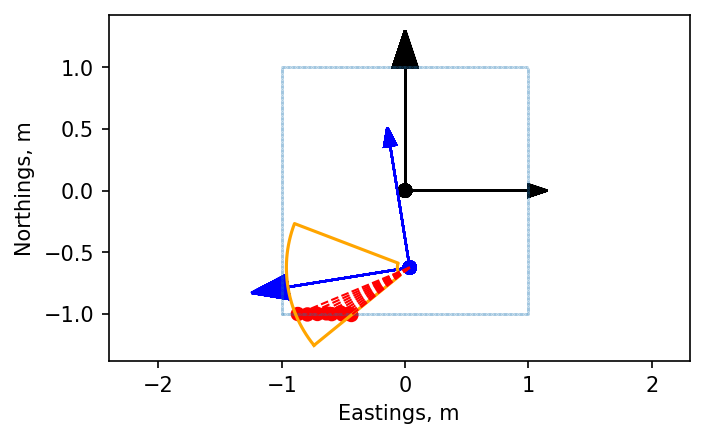

Max inflection value is  0.006414201708286334 : Threshold  0.01


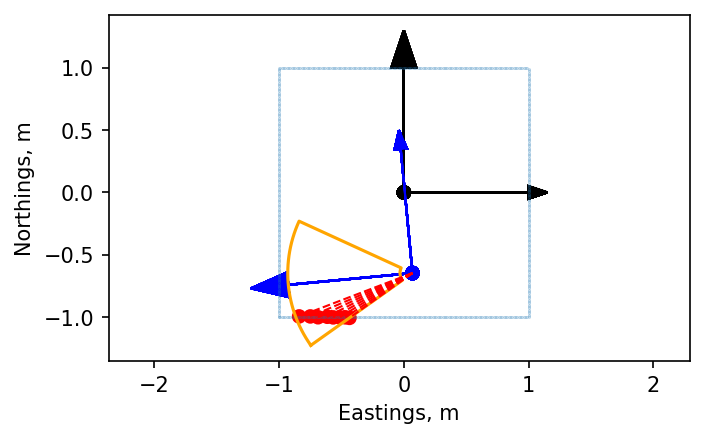

Max inflection value is  0.0022204201125567563 : Threshold  0.01


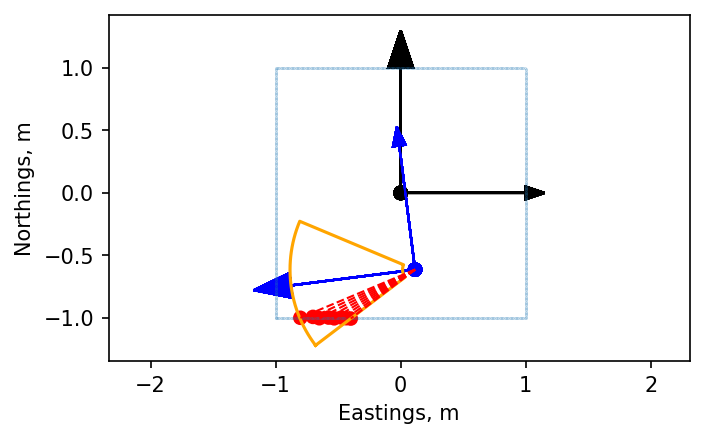

Max inflection value is  0.0035271566063750787 : Threshold  0.01


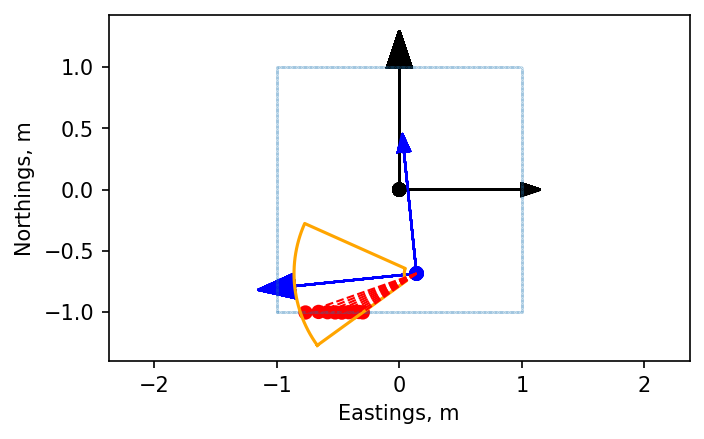

Max inflection value is  0.004229958561000065 : Threshold  0.01


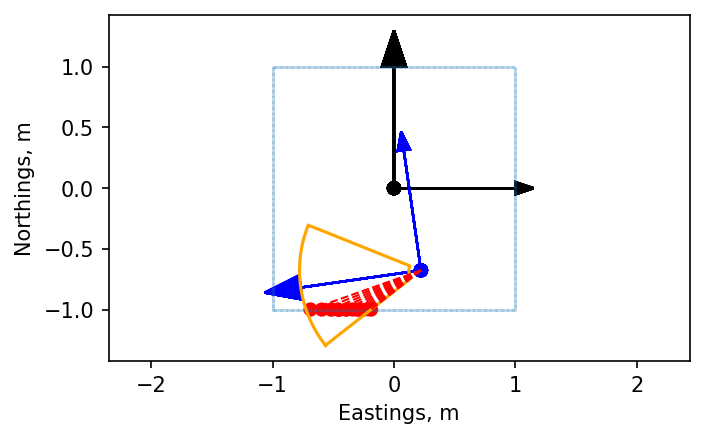

Max inflection value is  0.0061482301469220554 : Threshold  0.01


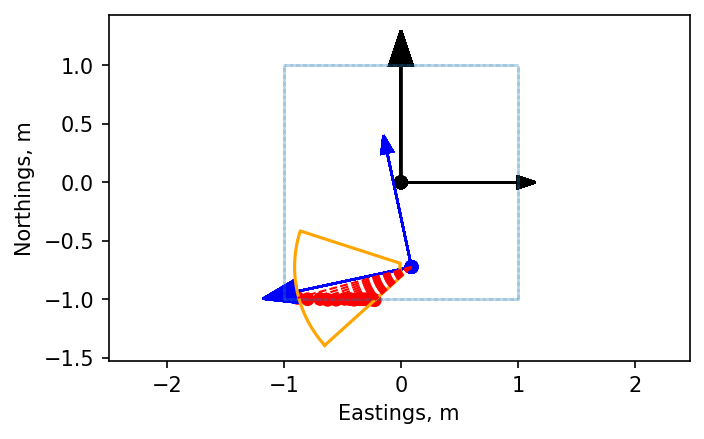

Max inflection value is  0.007638750870719219 : Threshold  0.01


In [18]:
pos_noise_std = 0.1
heading_noise_std = 10

# decide some random position and angular offsets to make sure the training data is varied
for i in range(40):    
    # determine basic pose for each wall
    if i<=10: # west wall
        p[0] = -0.2
        p[1] = -0.6
        p[2] = np.deg2rad(0)
    elif i<=20: # north wall
        p[0] = 0.6
        p[1] = -0.2
        p[2] = np.deg2rad(90)
    elif i<=30: # east
        p[0] = 0.2
        p[1] = 0.6
        p[2] = np.deg2rad(180)
    else:
        p[0] = -0.6
        p[1] = 0.2
        p[2] = np.deg2rad(270)

    # add random offsets
    p[0] += np.random.normal(-pos_noise_std, pos_noise_std)
    p[1] += np.random.normal(-pos_noise_std, pos_noise_std)
    p[2] += np.deg2rad(np.random.normal(-heading_noise_std, heading_noise_std))
    
    # compute observations with noise
    observation, _ = lidar_scan(p, environment_map, lidar, sigma_observe)
    fig,ax = plt.subplots()
    show_scan(p, lidar, observation)
    ax.scatter(m_y, m_x,s=0.01)
    plt.show()

    # check if it is a corner with the inflection point
    new_observation = GPC_input_output(observation, None)    
    threshold = 0.01 # can reduce to make less conservative
    _, _, loc = find_corner(new_observation, threshold)    

    # if no corner is found, register as a not corner for the training
    if loc is None:        
        new_observation.label='not corner'        
        corner_training.append(new_observation)


Train a GP classifier with these examples. Note we use `data_filled` which fills all range nan values with 0 and shift to the mean of other measurements to ignore range and only consider shape. In practice may want to increase the number of training examples, and can include more classes as needed. 

First check training data looks ok

In [19]:
for i in range(len(corner_training)):
    print('Entry:',i,', Class',corner_training[i].label, ', Size',corner_training[i].data_filled[:,0].size)
    print('Data',corner_training[i].data_filled[:,0])

Entry: 0 , Class corner , Size 30
Data [-0.28886036 -0.242702   -0.20458509 -0.14038949 -0.08726417  0.01387419
  0.05817627  0.06017546  0.04609791  0.03903582  0.03302383  0.01190389
  0.01602256  0.01722126  0.00787481  0.01434184  0.00251978  0.00572187
  0.0263382   0.02828591  0.01751594  0.04837189  0.05475537  0.0651334
  0.09085532  0.09220346  0.09909401  0.11525809  0.          0.        ]
Entry: 1 , Class corner , Size 30
Data [-0.12619971 -0.12461206 -0.11337749 -0.11436408 -0.11015608 -0.10174165
 -0.09321896 -0.08879158 -0.066449   -0.08191499 -0.0589     -0.0489748
 -0.04024122 -0.02968678 -0.00881755  0.00140214  0.01275392  0.05135633
  0.07214392  0.09094165  0.11732195  0.1385899   0.13250197  0.10668109
  0.09680265  0.09112843  0.08290072  0.08019847  0.06684183  0.06588096]
Entry: 2 , Class corner , Size 30
Data [ 0.03862537  0.0338761   0.04119659  0.04035954  0.05005671  0.0598327
  0.06409014  0.05756168  0.06622031  0.0716952   0.08666947  0.0985464
  0.09345

Store these in the right format for GPC

In [20]:
# preallocate memory for the training data, inputs are each scan, outputs are the class
X_train = np.full((len(corner_training), corner_training[0].data_filled[:,0].size), None)
y_train = np.full(len(corner_training), None, dtype=object)

# populate with the training data
for i in range(len(corner_training)):
    X_train[i,:]= corner_training[i].data_filled[:,0]
    if i == 1:
        print(X_train[i,:])
    y_train[i]= corner_training[i].label

# train the classifier
kernel = 1.0 * RBF(1.0)
gpc_corner = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(X_train, y_train)
print(gpc_corner.score(X_train, y_train))
print(gpc_corner.classes_)

# Obtain optimized kernel parameters
sklearn_theta_1 = gpc_corner.kernel_.k2.get_params()['length_scale']
sklearn_theta_0 = np.sqrt(gpc_corner.kernel_.k1.get_params()['constant_value'])

print(f'Optimized theta = [{sklearn_theta_0:.3f}, {sklearn_theta_1:.3f}], negative log likelihood = {-gpc_corner.log_marginal_likelihood_value_:.3f}')

[-0.1261997137169854 -0.12461205541120984 -0.1133774886457466
 -0.1143640830372859 -0.11015607710463576 -0.10174164574735395
 -0.09321895851488987 -0.08879157522502812 -0.06644900408785454
 -0.08191499105236166 -0.05890000057271566 -0.04897479910444785
 -0.040241215989602896 -0.029686776515940982 -0.008817549837155159
 0.0014021448000655634 0.012753918088044047 0.05135633178168675
 0.07214391661167396 0.0909416518062689 0.11732194854389022
 0.13858989843434844 0.1325019687443758 0.1066810948196546
 0.09680264592765364 0.09112843497131962 0.08290071815955014
 0.08019847390164214 0.06684183076745975 0.06588095720558218]
1.0
['corner' 'not corner']
Optimized theta = [9.232, 0.309], negative log likelihood = 21.039


Test classification using a new measurement set
- Try changing eastings to see just the wall, then the corner

- **Task:** Try p=[0.8, 0.2, 100deg].T for corner, then try  p=[0.8, -0.6, 80deg].T for non corner

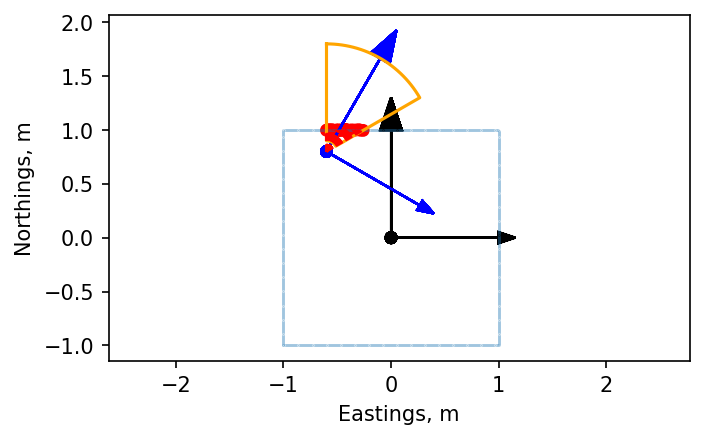

[[ 0.19804638 -0.52359878]
 [ 0.20137656 -0.48748852]
 [        nan -0.45137825]
 [ 0.20209506 -0.41526799]
 [ 0.20061451 -0.37915773]
 [ 0.20517865 -0.34304747]
 [        nan -0.30693721]
 [ 0.20838116 -0.27082695]
 [ 0.20684943 -0.23471669]
 [ 0.20844681 -0.19860643]
 [        nan -0.16249617]
 [ 0.21118985 -0.12638591]
 [ 0.22003481 -0.09027565]
 [ 0.22247668 -0.05416539]
 [ 0.22907097 -0.01805513]
 [ 0.22812263  0.01805513]
 [ 0.23907066  0.05416539]
 [ 0.24226012  0.09027565]
 [ 0.25039391  0.12638591]
 [ 0.25849697  0.16249617]
 [ 0.27422926  0.19860643]
 [ 0.27337893  0.23471669]
 [ 0.27813636  0.27082695]
 [ 0.29409761  0.30693721]
 [ 0.31005662  0.34304747]
 [ 0.31948139  0.37915773]
 [ 0.33892744  0.41526799]
 [ 0.36148143  0.45137825]
 [ 0.37287523  0.48748852]
 [ 0.39304202  0.52359878]]
30
New observation is  not corner , with probabilities [[0.49888813 0.50111187]]
No landmark


In [26]:
# new pose and lidar location
p[0] = 0.8 #Northings
p[1] = -0.6 #Eastings
p[2] = np.deg2rad( 30 ) #Heading (rad)

# generate new observation and scan it
observation, _ = lidar_scan(p, environment_map, lidar, sigma_observe)
fig,ax = plt.subplots()
show_scan(p, lidar, observation)
ax.scatter(m_y, m_x,s=0.01)
plt.show()

print(observation)
print(len(observation))

# log the scan for classification
new_observation = GPC_input_output(observation, None)

# Use classifier to judge if it is a corner or not, can increase this to be more conservative
threshold = 0.5
if np.max(gpc_corner.predict_proba([new_observation.data_filled[:,0]]))>=threshold:
    new_observation.label = (gpc_corner.classes_[np.argmax(gpc_corner.predict_proba([new_observation.data_filled[:,0]]))])
    print('New observation is ',new_observation.label, ', with probabilities', gpc_corner.predict_proba([new_observation.data_filled[:,0]]))
    

if new_observation.label == 'corner': 
    z_lm[0], z_lm[1], loc = find_corner(new_observation, 0.006) # we can set a lower threshold here

    if loc is not None:  
        # plot the raw sensor readings
        plt.plot(np.rad2deg(observation[:, 1]), observation[:, 0], 'g.', label='Observations')
        plt.plot(np.rad2deg(observation[loc, 1]), observation[loc, 0], 'ro', label='Observations')
        plt.xlabel('Bearing (sensor frame), degrees')
        plt.ylabel('Range, m')
        plt.show()

        new_observation.ne_representative=lidar.rangeangle_to_loc(p,z_lm)
         
        # determine location of 
        H_eb = HomogeneousTransformation(p[0:2],p[2])
        H_el.H = H_eb.H@lidar.H_bl.H        
        plot_2dframe(['observation','b','l','m'],[H_eb.H,H_el.H,z_lm],True)
        plt.scatter(m_x, m_y,s=0.1)
        plt.axis('equal')
        plt.show()
        
        print('Map observation made at, Northings = ',new_observation.ne_representative[0],'m, Eastings =',new_observation.ne_representative[1],'m')        
        corner_training.append(new_observation)
    else: print('Could not find inflection point')        

else: print('No landmark')

## <span style="color:green"> 3. Gaussian Process Regression </span> 

Next we implement GPs for regression. The theory overlaps with classification and it is a more direct application of GPs. Note, the sklearn library implements uncertainty prediction for the classifier directly.

In [22]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from plot_feeg6043 import plot_gpr_model, plot_gpr_likelihood
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel

Create a past observation and store them in a map

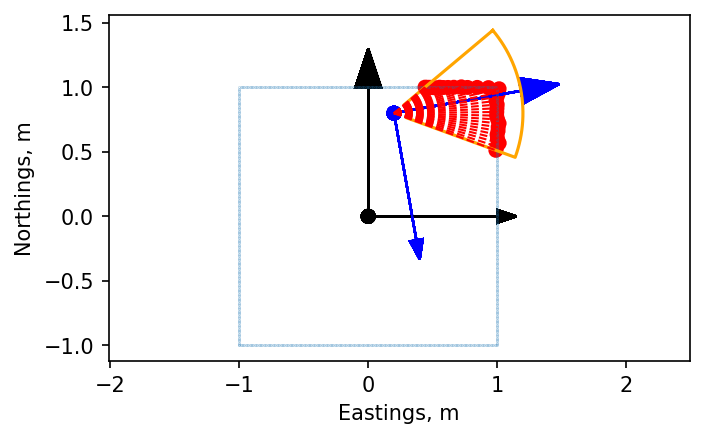

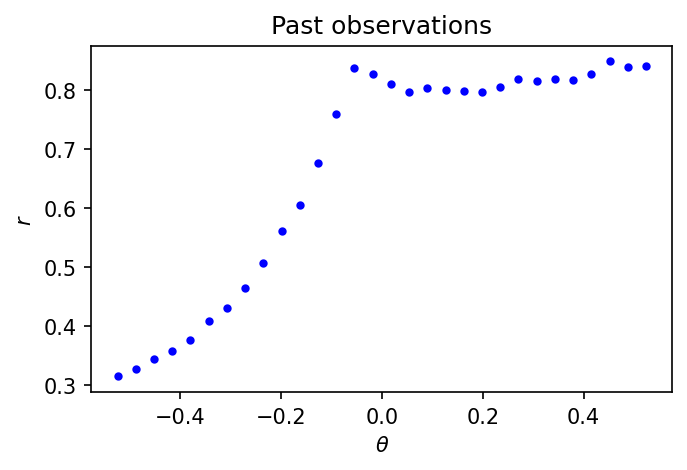

In [23]:
# previous pose and lidar location
p[0] = 0.8 #Northings
p[1] = 0.2 #Eastings
p[2] = np.deg2rad(80) #Heading (rad)

# past observation
past_observation, past_observation_std = lidar_scan(p, environment_map, lidar, sigma_observe)
fig,ax = plt.subplots()

# show it on the map
show_scan(p, lidar, past_observation)
ax.scatter(m_y, m_x,s=0.01)
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot past observations sensor reading
ax.scatter(
    past_observation[:,1],
    past_observation[:,0],
    c="blue",
    marker=".",
    label="Past observations",
)
ax.set_xlabel("$\\theta$")
ax.set_ylabel("$r$")
ax.set_title("Past observations")

# store measurement locations in a map in the e-frame
z_lm = Vector(2)
northings_map = []; eastings_map = []
for i in range(len(past_observation[:,0])):
    z_lm[0] = past_observation[i,0]
    z_lm[1] = past_observation[i,1]
    
    x,y = lidar.rangeangle_to_loc(p,z_lm)
    
    northings_map.append(x)
    eastings_map.append(y)

past_observations_ne = l2m([northings_map, eastings_map])

Generate some new observations in an overlapping region of the environment and look at the likelihood of those with and without errors in the robot's pose.

1. We first project past observations into the current sensor frame, taking into account the robot's pose and the lidar FOV and range.
2. Next these past observations are used to train GPR and the trained GPR is used to predict the exact range measurements the robot expects to observe along each of its lidar scan directions
3. The likelihood of those is calculated for that pose

- **Task 1:** With no error first
- **Task 2:** With a small pose error

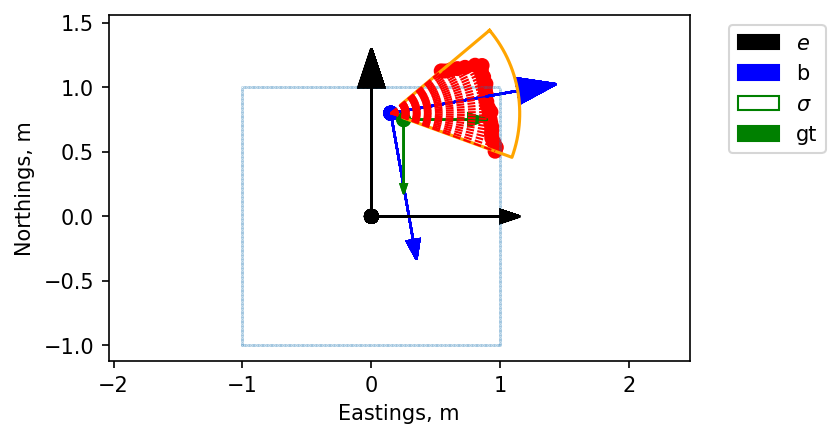

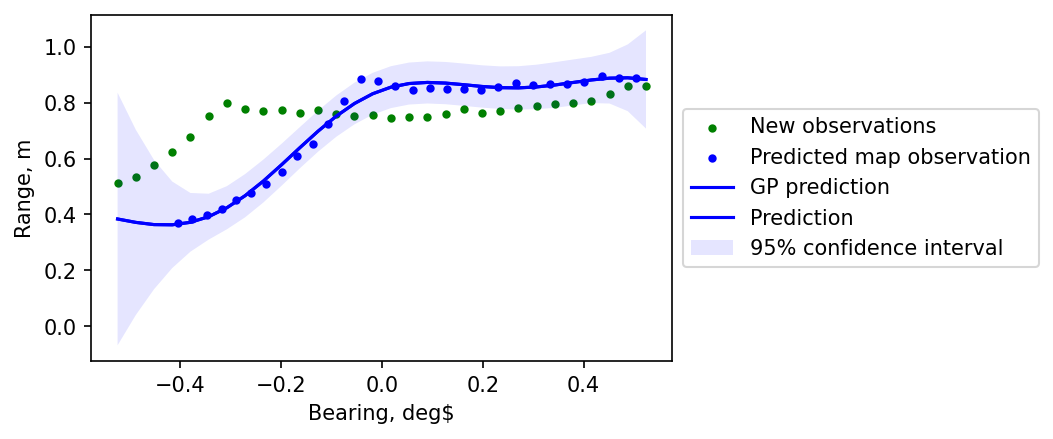

In [24]:
# The position error between the true and estimated pose
northings_error = 0.05
eastings_error = -0.1
heading_error = -np.deg2rad(10)

# True pose that the robot does not know. The observations will be made relative to this
p_true=Vector(3)
p_true[0] = 0.75 #Northings
p_true[1] = 0.25 #Eastings
p_true[2] = np.deg2rad(90) #Heading (rad)

# Estimated pose with error
p_est=Vector(3)
p_est[0] = p_true[0]+northings_error
p_est[1] = p_true[1]+eastings_error
p_est[2] = p_true[2]+heading_error

############################# STEP  1##################################
# Based on the estimated pose, predict where previous observations would appear in the lidar scan
predicted_map_ranges = []; predicted_map_angles = []
for i in range(len(past_observations_ne)):
    z_lm = lidar.loc_to_rangeangle(p_est, past_observations_ne[[i],:].T )
    predicted_map_angles.append(z_lm[0][1])
    predicted_map_ranges.append(z_lm[0][0])    
predicted_map_observations = l2m([predicted_map_ranges, predicted_map_angles])

# Remove any NaN values (i.e., outside of the sensor FOV or range)
mask = ~np.isnan(predicted_map_observations).any(axis=1)  # only keeps rows where all values are not nan
clean_observations = predicted_map_observations[mask]

############################# STEP 2 ##################################
# train the gp based othese, we can use fixed length scales and assume a map uncertainty for now
kernel = ConstantKernel(np.mean(clean_observations[:,[0]])) + RBF(length_scale=0.3,length_scale_bounds="fixed")
gp = GaussianProcessRegressor(kernel=kernel, alpha = 0.1**2)
gp.fit( clean_observations[:,[1]], clean_observations[:,[0]] )


# register new observations, noting these will be made from where the robot actually is
new_observation, new_observation_std = lidar_scan( p_true, environment_map, lidar, sigma_observe)
fig,ax = plt.subplots()
show_scan( p_est, lidar, new_observation) # show what the robot thinks it has seen
ax.scatter(m_y, m_x,s=0.01)

# plot where the robot actually is 
H_eb = HomogeneousTransformation(p_true[0:2],p_true[2])   
plot_2dframe(['pose_gt','gt','gt'],[H_eb.H,H_eb.H],False)
plt.axis('equal')
plt.show()


# Plot the new observations
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(
    new_observation[:,1],
    new_observation[:,0],
    c="green",
    marker=".",
    label="New observations",
)

# Plot the predicted map observations
ax.scatter(
    predicted_map_observations[:,1],
    predicted_map_observations[:,0],
    c="blue",
    marker=".",
    label="Predicted map observation",
)

# For new observations that made an actual reading, predict what these should be based on the GPR
mask = ~np.isnan(new_observation).any(axis=1)  # Keeps rows where all values are not NaN
new_observations = new_observation[mask]
new_observations_std = new_observation_std[mask]

new_range_pred, new_std_pred = gp.predict(new_observations[:,[1]], return_std=True)
ax.plot(new_observations[:,1], new_range_pred,  c="blue",label="GP prediction")

# plotting function with model x, predicted y and predicted std values
modeled = [new_observations[:,1],new_range_pred, new_std_pred]
plot_gpr_model(modeled ) 

We generate our predictions of each observation, and calculate the likelihood of the new observations using the sum of Gaussians as the std:

\begin{equation}
p = \frac{1}{\sqrt{2\pi\sigma_{\text{sum}}^2}} \exp\left(-\frac{(\mu_{\text{obs}} - \mu_{\text{pred}})^2}{2 \sigma_{\text{sum}}^2}\right), \quad \text{where} \quad \sigma_{\text{sum}}^2 = \sigma_{\text{obs}}^2 + \sigma_{\text{pred}}^2
\end{equation}


Likelihood of observation 1.6969643546404114


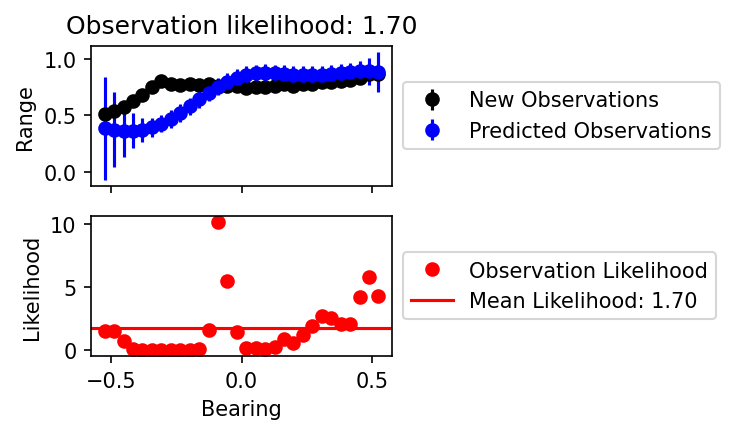

In [25]:
# # calculate probability
distance = new_range_pred - new_observations[:,0]
sum_squared_stds = (new_std_pred**2 + new_observations_std[:,0]  ** 2)
likelihood = np.exp(-0.5 * (distance) ** 2 / sum_squared_stds) / np.sqrt(2 * np.pi * sum_squared_stds)

full_likelihood = 0
for i in range(len(new_observations[:,0])):
    full_likelihood += likelihood[i]
print('Likelihood of observation', full_likelihood/len(new_observations[:,0]))

plot_gpr_likelihood([new_observations[:,1], new_observations[:,0], new_observations_std[:,0]],[new_range_pred, new_std_pred],likelihood)

The results show that the first past observation was a much better match than the second. The observation likelihood can be used to directly calculate weights in a PF model. Notice how we can:
- Make use of a wall, which is "featureless" to reject a current observation
- Makes use of areas with no past observations. Most of the uncertainty in the wall scenario comes from the fact we had new observations in areas where we saw nothing previously. The GP uncertainty grows significanly in this area, resulting in a very low observation likelhood

## Wrap up

You should now understand how to do:
- Classification: Identifying the same landmark object in re-observations
- Regression: Determining the likelihood of re-observations based on continuous models of previous observations

In particular, classifiers can deal with positive information but regression allows us to make use of no information, which can be useful in some robotic scenarios.